In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
from model_common import *

In [3]:
!nvidia-smi

Fri Dec  3 11:01:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_chroma.pkl')
gpu, cpu = get_devices()

In [5]:
class ChromaMatrixDataset(AbsDataset):
    def __init__(self, labels, chromas):
        super().__init__()
        self.labels = labels
        self.chromas = chromas

    def __get__(self,index):
      if self.chromas[index].shape[1] < 1876:
        self.chromas[index] = torch.hstack((self.chromas[index],torch.zeros(12,1876-self.chromas[index].shape[1])))
      return self.chromas[index].reshape((1,)+self.chromas[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaMatrixDataset(train_lbls, train_vals)
      test_data = ChromaMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [6]:
class ChromaRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.1):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1 , kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(11256,1000),nn.ReLU(),nn.Linear(1000,n_labels))
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [7]:
ragam_te_to_en = {
    'సామంతం' : 'Samantham',
    'దేసాళం' : 'Desalam',
    'రామక్రియ' : 'Ramakriya',
    'కన్నడగౌళ' : 'Kannadagowla',
    'శంకరాభరణం' : 'Sankarabharanam',
    'దేవగాంధారి' : 'Devagandhari',
    'ఆహిరి' : 'Aahiri',
    'ముఖారి' : 'Mukhari',
    'నాట' : 'Naata',
    'శుద్ధవసంతం' : 'Suddavasantham',
    'సాళంగనాట' : 'Salanganata',
    'లలిత' : 'Lalitha',
    'భూపాలం' : 'Bhupalam',
    'ధన్నాసి' : 'Dhannasi',
    'కాంబోది' : 'Kambodhi',
    'బౌళి' : 'Bauli',
    'గుండుక్రియ' : 'Gundukriya',
    'శ్రీరాగం' : 'Sriragam',
    'భైరవి' : 'Bhairavi',
    'పాడి' : 'Paadi',
    'మాళవి' : 'Maalavi',
    'నాదరామక్రియ' : 'Nadaramakriya',
    'మలహరి' : 'Malahari',
    'వరాళి' : 'Varali',
    'గౌళ' : 'Gowla',
    'సాళంగం' : 'Salangam',
    'బౌళిరామక్రియ' : 'Bauliramakriya',
    'మాళవిగౌళ' : 'Malavigowla',
    'గుజ్జరి' : 'Gujjari',
    'దేసాక్షి' : 'Desakshi'
}

In [8]:
data['Ragam'].replace(ragam_te_to_en,inplace=True)

In [9]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='chroma', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=None):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    if nindex_factor:
      np.random.seed(42)
      ndata = pd.DataFrame()
      ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      ndata[feature] = data[feature]
      pindex = ndata[ndata[target]==1].index
      nindex = ndata[ndata[target]==0].index
      index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
      tdata = ndata.loc[index]
    else:
      tdata = pd.DataFrame()
      tdata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      tdata[feature] = data[feature]

    
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Aahiri'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 216/54
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.728 / Validation Loss : 0.689 [Time : 0.523502 seconds]
Epoch 2/15 : Training Loss: 0.650 / Validation Loss : 0.658 [Time : 0.180298 seconds]
Epoch 3/15 : Training Loss: 0.596 / Validation Loss : 0.639 [Time : 0.175001 seconds]
Epoch 4/15 : Training Loss: 0.556 / Validation Loss : 0.633 [Time : 0.164185 seconds]
Epoch 5/15 : Training Loss: 0.530 / Validation Loss : 0.634 [Time : 0.076063 seconds]
Epoch 6/15 : Training Loss: 0.517 / Validation Loss : 0.639 [Time : 0.083633 seconds]
Epoch 7/15 : Training Loss: 0.508 / Validation Loss : 0.646 [Time : 0.068888 seconds]
Epoch 8/15 : Training Loss: 0.503 / Validation Loss : 0.652 [Time : 0.068846 seconds]
Epoch 9/15 : Training Loss: 0.504 / Validation Loss : 0.658 [Time : 0.067418 seconds]
Epoch 10/15 : Training Loss: 0.502 / Validation Loss : 0.663 [Time : 0.069014 seconds]
Epoch 11/15 : Training

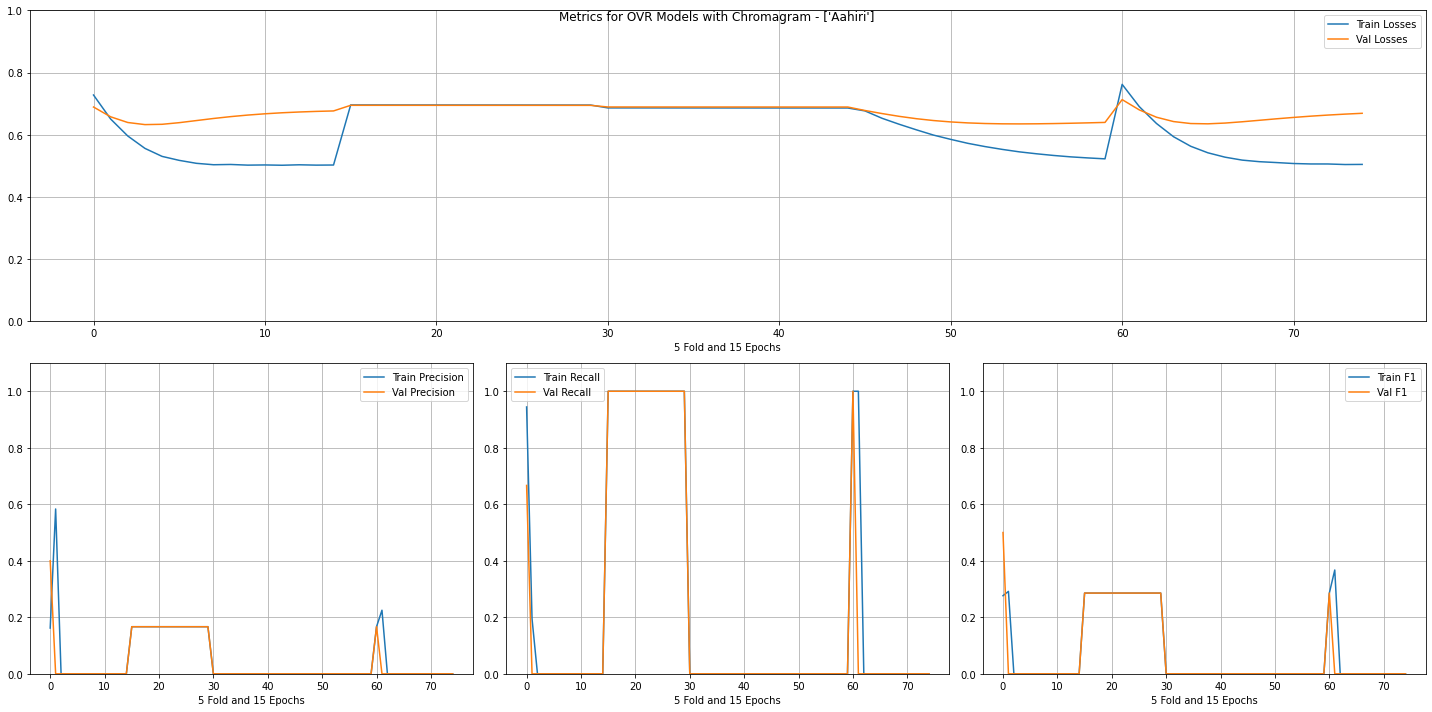

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.276423       0.500000  ...      0.727753           0.689147
0   0.285714       0.285714  ...      0.695744           0.694621
1   0.285714       0.285714  ...      0.695721           0.694609
2   0.285714       0.285714  ...      0.695699           0.694597
3   0.285714       0.285714  ...      0.695676           0.694584
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.507342           0.655652
11  0.000000       0.000000  ...      0.505926           0.659710
12  0.000000       0.000000  ...      0.505868           0.663230
13  0.000000       0.000000  ...      0.504093           0.666279
14  0.000000       0.000000  ...      0.504467           0.668926

[75 rows x 12 columns]
Training for ['Bauli'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.722 / Validation Loss : 0.694 [Time : 0

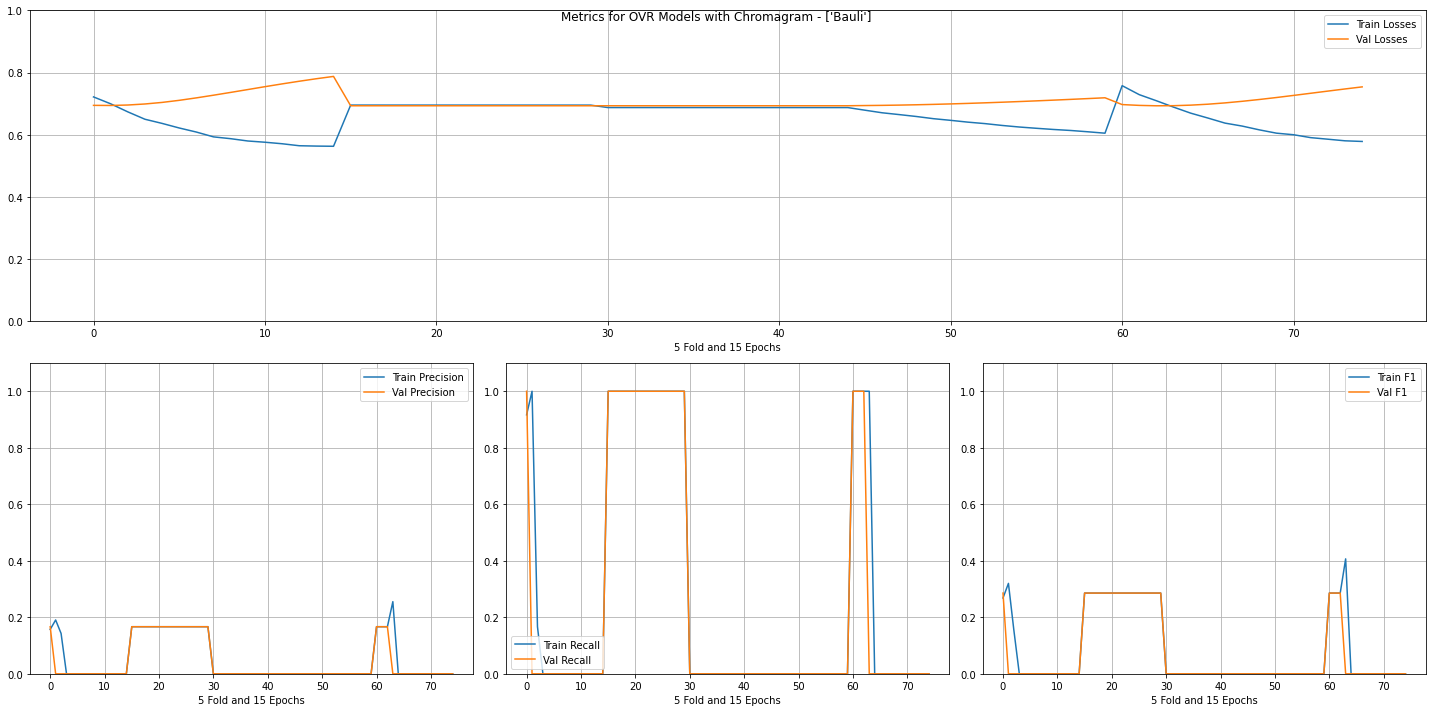

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.230769,0.162162,0.4,0.0,0.0,0.0,0.269663,0.173913,0.6


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.695331           0.693157
1   0.285714       0.285714  ...      0.695323           0.693156
2   0.285714       0.285714  ...      0.695316           0.693156
3   0.285714       0.285714  ...      0.695309           0.693156
4   0.285714       0.285714  ...      0.695301           0.693156
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.599939           0.726465
11  0.000000       0.000000  ...      0.590614           0.733393
12  0.000000       0.000000  ...      0.585574           0.740363
13  0.000000       0.000000  ...      0.580400           0.747243
14  0.000000       0.000000  ...      0.578322           0.753927

[75 rows x 12 columns]
Training for ['Bauliramakriya'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 91/23
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.726 / Validation Loss : 0.690 

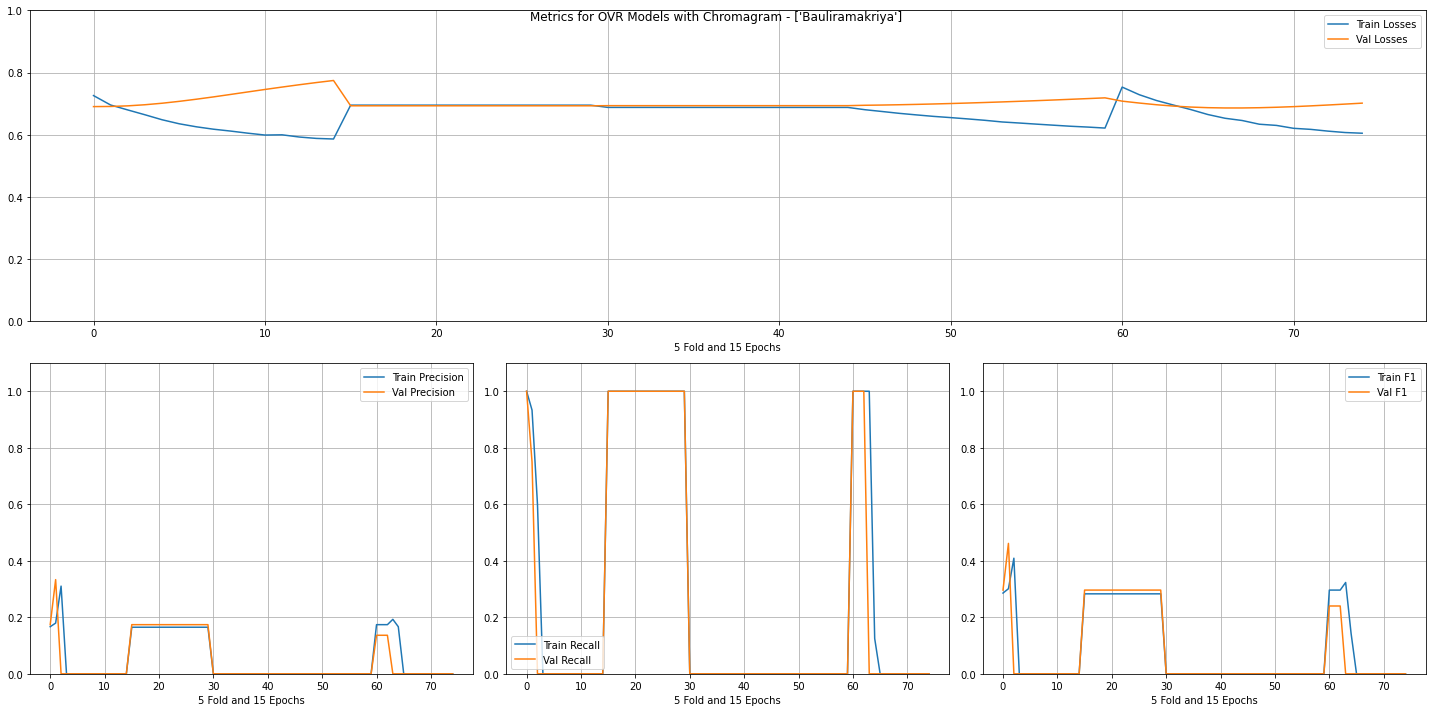

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.246154,0.173913,0.421053,0.0,0.0,0.0,0.233463,0.165746,0.394737


    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.301075       0.461538  ...      0.695523           0.690926
0   0.285714       0.296296  ...      0.725932           0.690482
0   0.283019       0.296296  ...      0.695142           0.693045
1   0.283019       0.296296  ...      0.695135           0.693045
2   0.283019       0.296296  ...      0.695130           0.693046
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.620611           0.690340
11  0.000000       0.000000  ...      0.617220           0.692817
12  0.000000       0.000000  ...      0.611597           0.695583
13  0.000000       0.000000  ...      0.607062           0.698530
14  0.000000       0.000000  ...      0.604810           0.701589

[75 rows x 12 columns]
Training for ['Bhairavi'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 134/34
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.722 / Validation Loss : 0.695 [Time

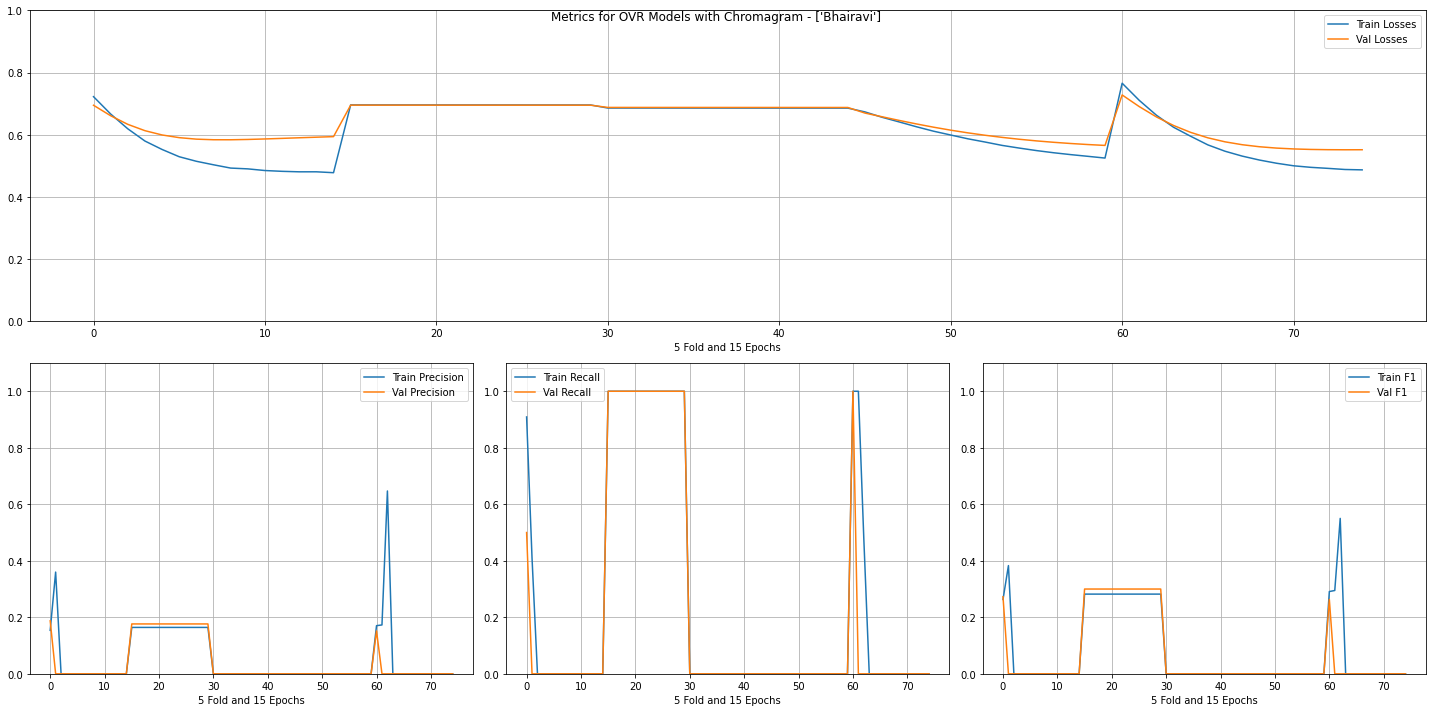

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.193548,0.176471,0.214286,0.0,0.0,0.0,0.178862,0.164179,0.196429


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.282051            0.3  ...      0.695907           0.695166
1   0.282051            0.3  ...      0.695890           0.695155
2   0.282051            0.3  ...      0.695873           0.695143
3   0.282051            0.3  ...      0.695856           0.695130
4   0.282051            0.3  ...      0.695839           0.695118
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.500030           0.554252
11  0.000000            0.0  ...      0.495080           0.552651
12  0.000000            0.0  ...      0.491756           0.551825
13  0.000000            0.0  ...      0.488116           0.551559
14  0.000000            0.0  ...      0.486921           0.551671

[75 rows x 12 columns]
Training for ['Bhupalam'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.720 / Validation Loss : 0.694 [Time 

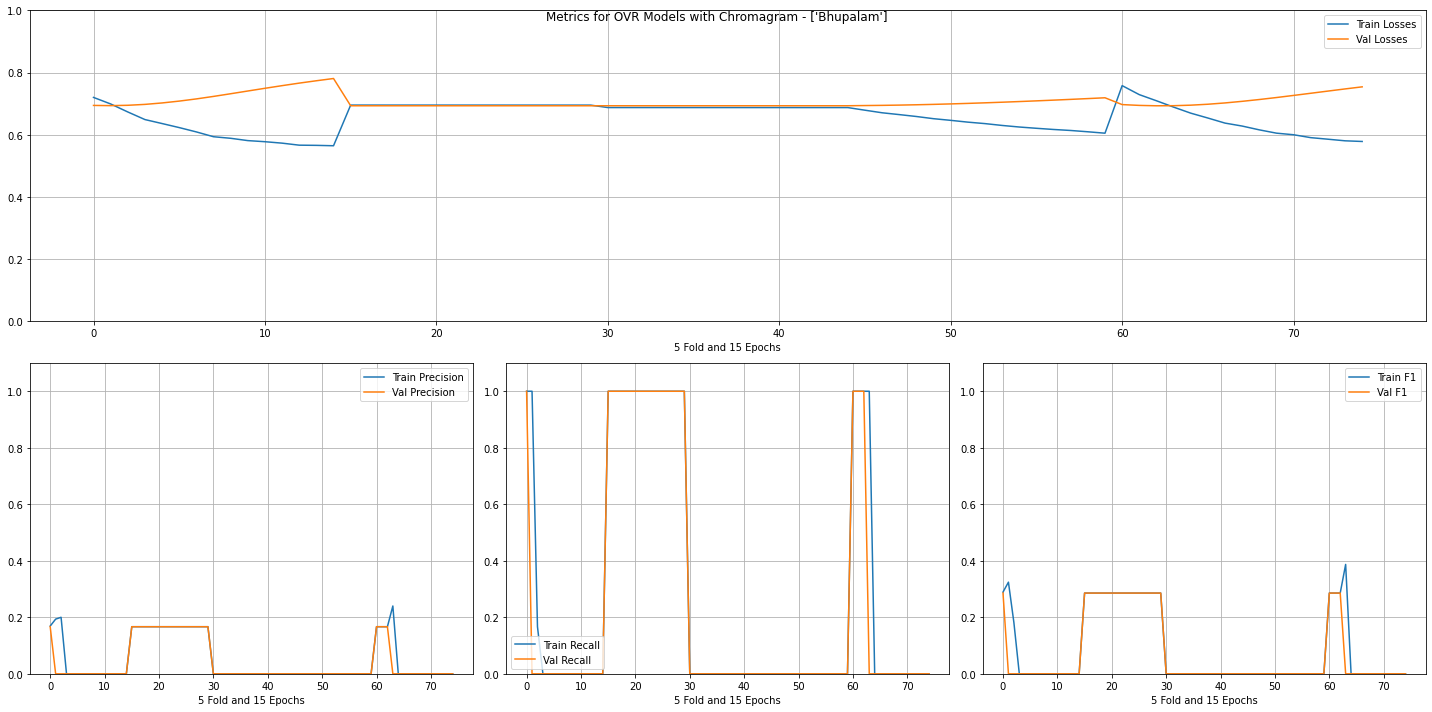

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.230769,0.162162,0.4,0.0,0.0,0.0,0.270677,0.174757,0.6


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.289157       0.285714  ...      0.720030           0.694274
0   0.285714       0.285714  ...      0.695331           0.693157
1   0.285714       0.285714  ...      0.695323           0.693156
2   0.285714       0.285714  ...      0.695316           0.693156
3   0.285714       0.285714  ...      0.695309           0.693156
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.599915           0.726433
11  0.000000       0.000000  ...      0.590598           0.733374
12  0.000000       0.000000  ...      0.585580           0.740374
13  0.000000       0.000000  ...      0.580419           0.747309
14  0.000000       0.000000  ...      0.578273           0.754042

[75 rows x 12 columns]
Training for ['Desakshi'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.721 / Validation Loss : 0.689 [Time 

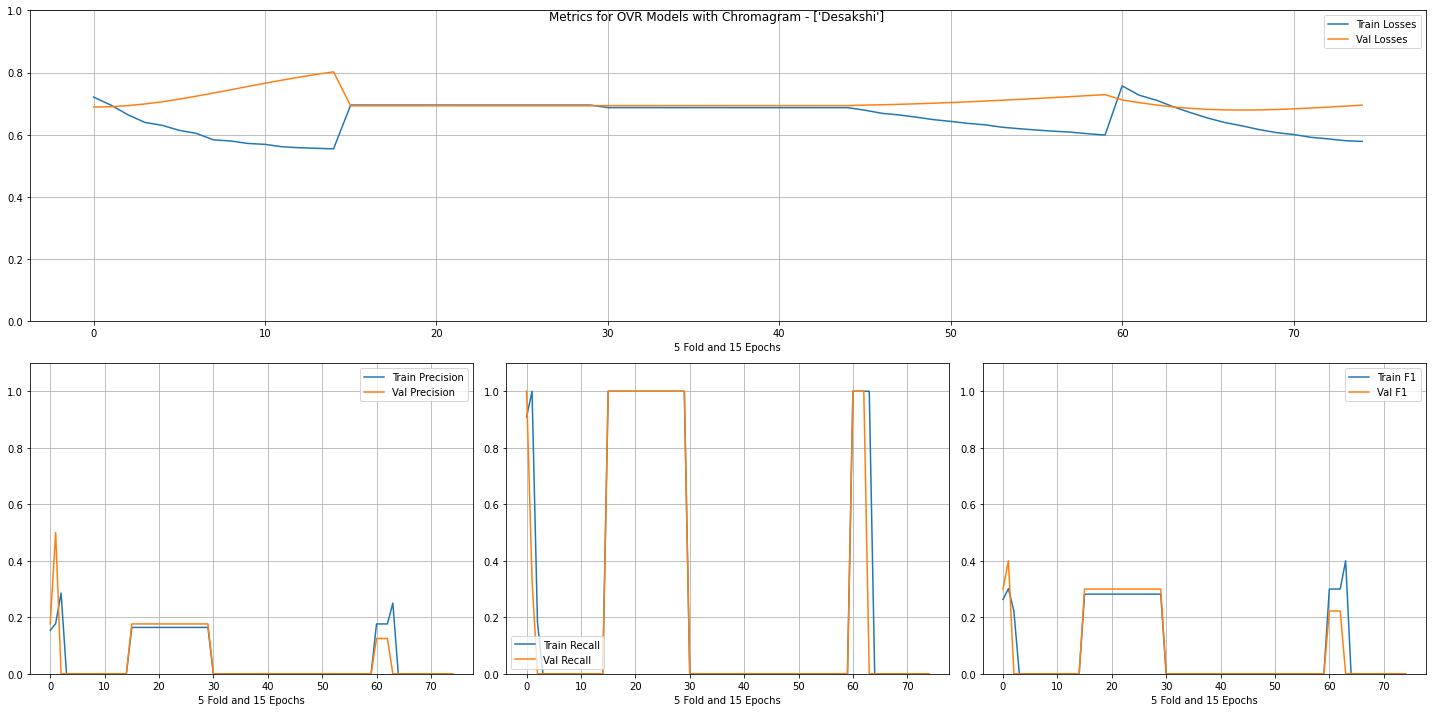

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.25,0.176471,0.428571,0.0,0.0,0.0,0.223404,0.159091,0.375


    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.301370            0.4  ...      0.695790           0.690083
0   0.282051            0.3  ...      0.695407           0.693007
1   0.282051            0.3  ...      0.695398           0.693007
2   0.282051            0.3  ...      0.695391           0.693008
3   0.282051            0.3  ...      0.695383           0.693008
..       ...            ...  ...           ...                ...
10  0.000000            0.0  ...      0.600645           0.683273
11  0.000000            0.0  ...      0.591718           0.685860
12  0.000000            0.0  ...      0.586642           0.688796
13  0.000000            0.0  ...      0.580890           0.691957
14  0.000000            0.0  ...      0.578486           0.695266

[75 rows x 12 columns]
Training for ['Desalam'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 168/42
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.723 / Validation Loss : 0.687 [Time 

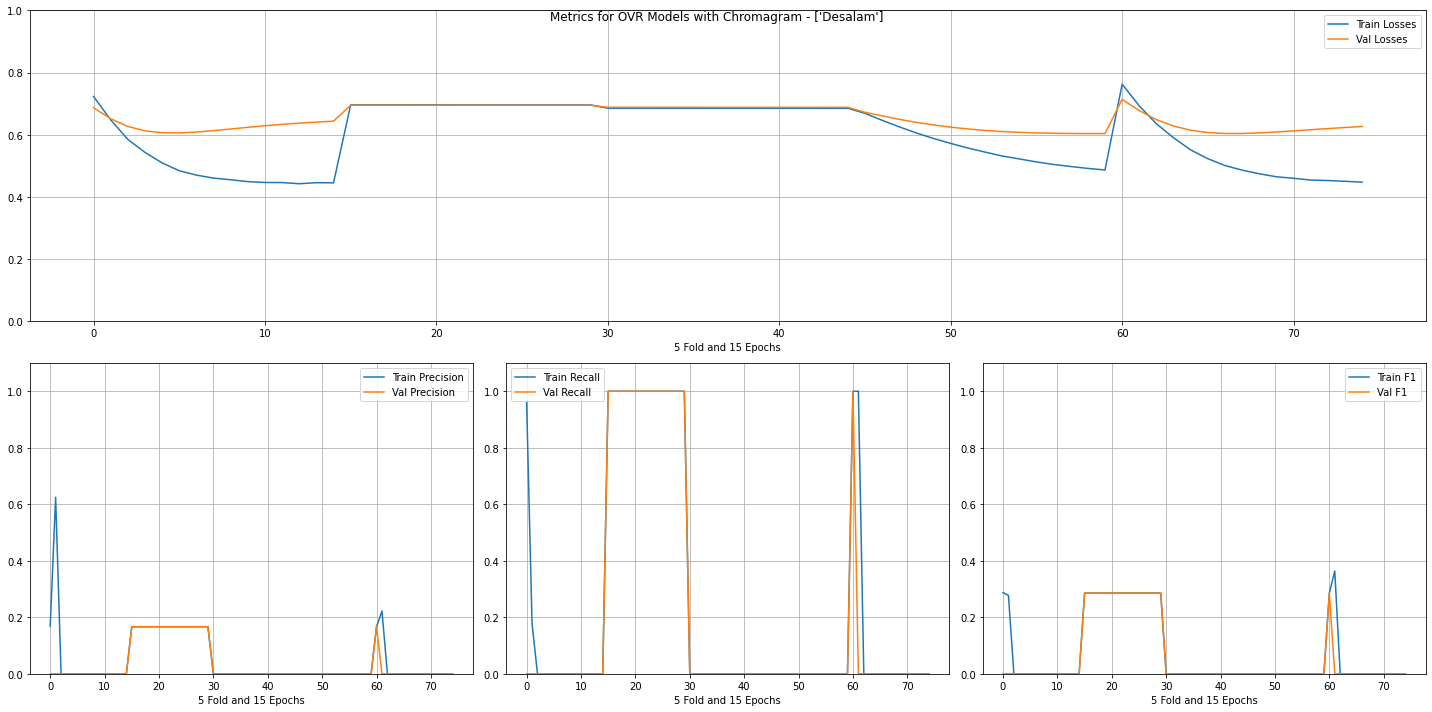

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.696091           0.694958
1   0.285714       0.285714  ...      0.696068           0.694945
2   0.285714       0.285714  ...      0.696045           0.694931
3   0.285714       0.285714  ...      0.696022           0.694917
4   0.285714       0.285714  ...      0.695999           0.694903
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.459753           0.612414
11  0.000000       0.000000  ...      0.454080           0.616105
12  0.000000       0.000000  ...      0.452570           0.619741
13  0.000000       0.000000  ...      0.450098           0.623282
14  0.000000       0.000000  ...      0.447409           0.626592

[75 rows x 12 columns]
Training for ['Devagandhari'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 139/35
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.724 / Validation Loss : 0.696 [

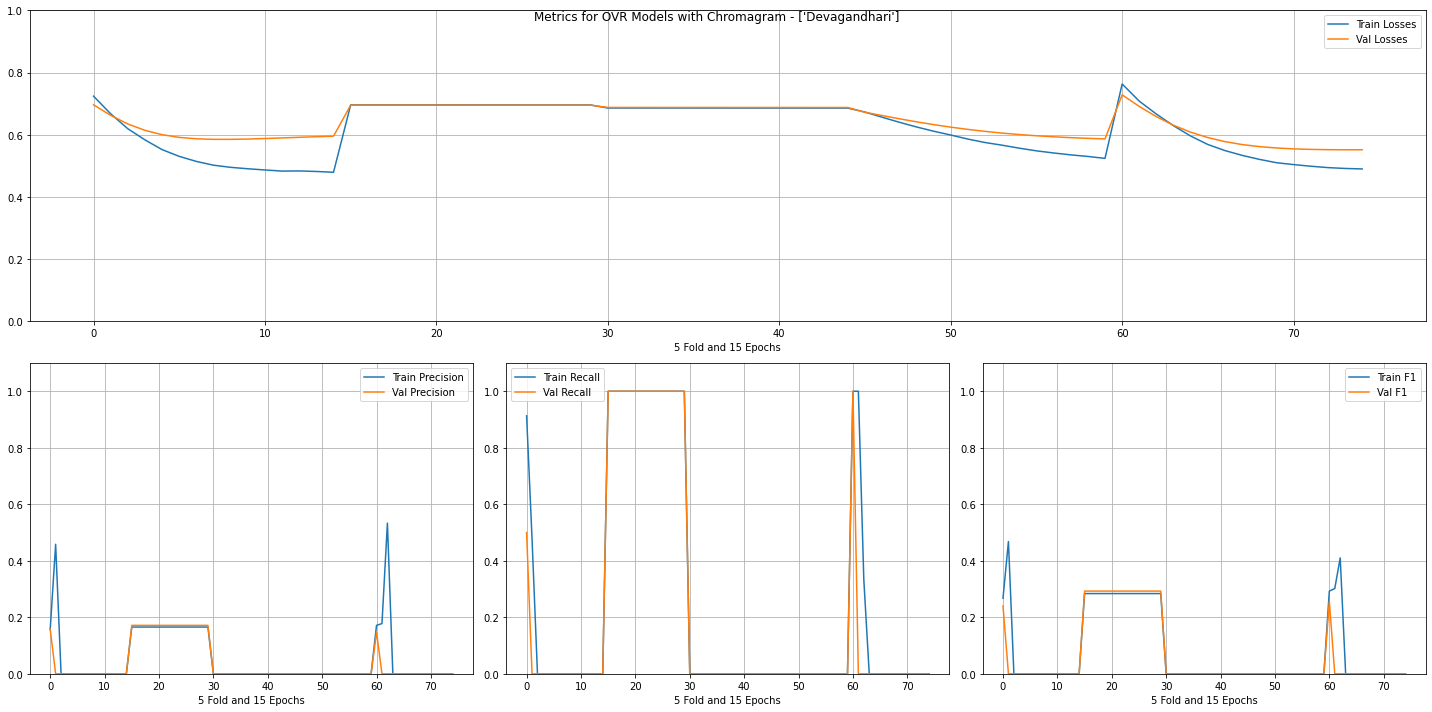

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.1875,0.171429,0.206897,0.0,0.0,0.0,0.180392,0.165468,0.198276


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.283951       0.292683  ...      0.695889           0.695166
1   0.283951       0.292683  ...      0.695872           0.695156
2   0.283951       0.292683  ...      0.695855           0.695143
3   0.283951       0.292683  ...      0.695839           0.695131
4   0.283951       0.292683  ...      0.695822           0.695118
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.503880           0.554473
11  0.000000       0.000000  ...      0.498615           0.552781
12  0.000000       0.000000  ...      0.494200           0.551885
13  0.000000       0.000000  ...      0.491444           0.551536
14  0.000000       0.000000  ...      0.489916           0.551568

[75 rows x 12 columns]
Training for ['Dhannasi'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 192/48
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.723 / Validation Loss : 0.689 [Time

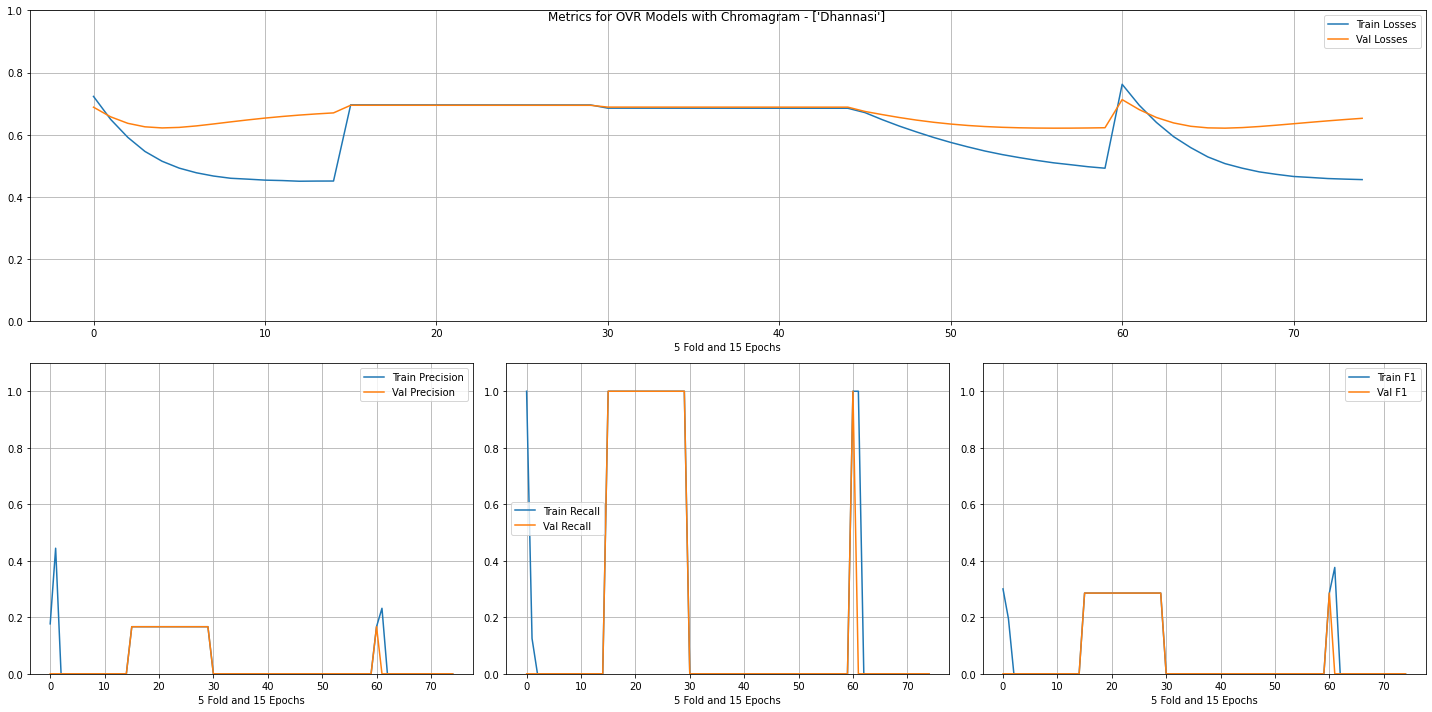

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.696051           0.694779
1   0.285714       0.285714  ...      0.696029           0.694767
2   0.285714       0.285714  ...      0.696007           0.694755
3   0.285714       0.285714  ...      0.695985           0.694743
4   0.285714       0.285714  ...      0.695963           0.694730
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.465639           0.635338
11  0.000000       0.000000  ...      0.462455           0.640081
12  0.000000       0.000000  ...      0.458994           0.644613
13  0.000000       0.000000  ...      0.457132           0.648871
14  0.000000       0.000000  ...      0.455582           0.652797

[75 rows x 12 columns]
Training for ['Gowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.725 / Validation Loss : 0.696 [Time : 0

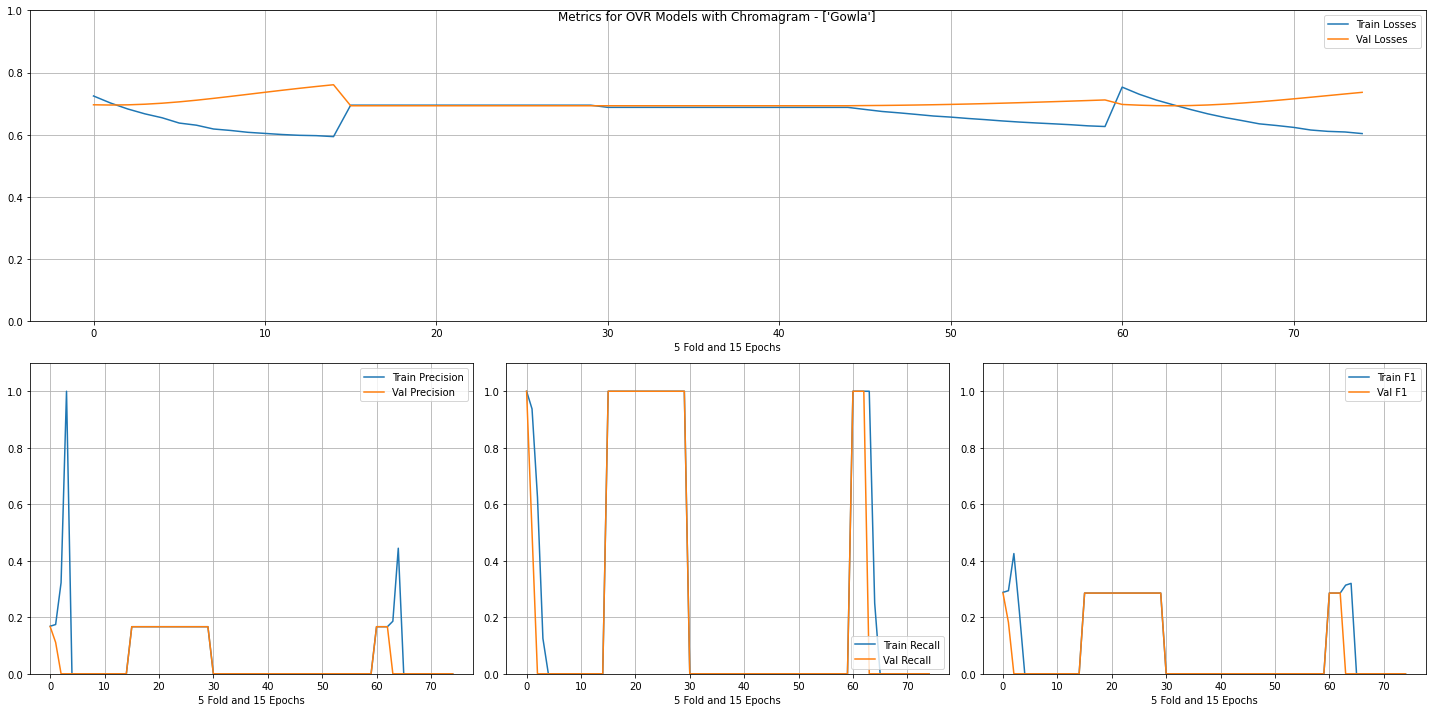

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.193548,0.142857,0.3,0.0,0.0,0.0,0.270115,0.175373,0.5875


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.288288       0.285714  ...      0.724651           0.696290
0   0.285714       0.285714  ...      0.695090           0.693156
1   0.285714       0.285714  ...      0.695083           0.693157
2   0.285714       0.285714  ...      0.695078           0.693157
3   0.285714       0.285714  ...      0.695072           0.693156
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.623622           0.715415
11  0.000000       0.000000  ...      0.615129           0.720582
12  0.000000       0.000000  ...      0.610780           0.725880
13  0.000000       0.000000  ...      0.608826           0.731182
14  0.000000       0.000000  ...      0.603657           0.736375

[75 rows x 12 columns]
Training for ['Gujjari'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.727 / Validation Loss : 0.689 [Time 

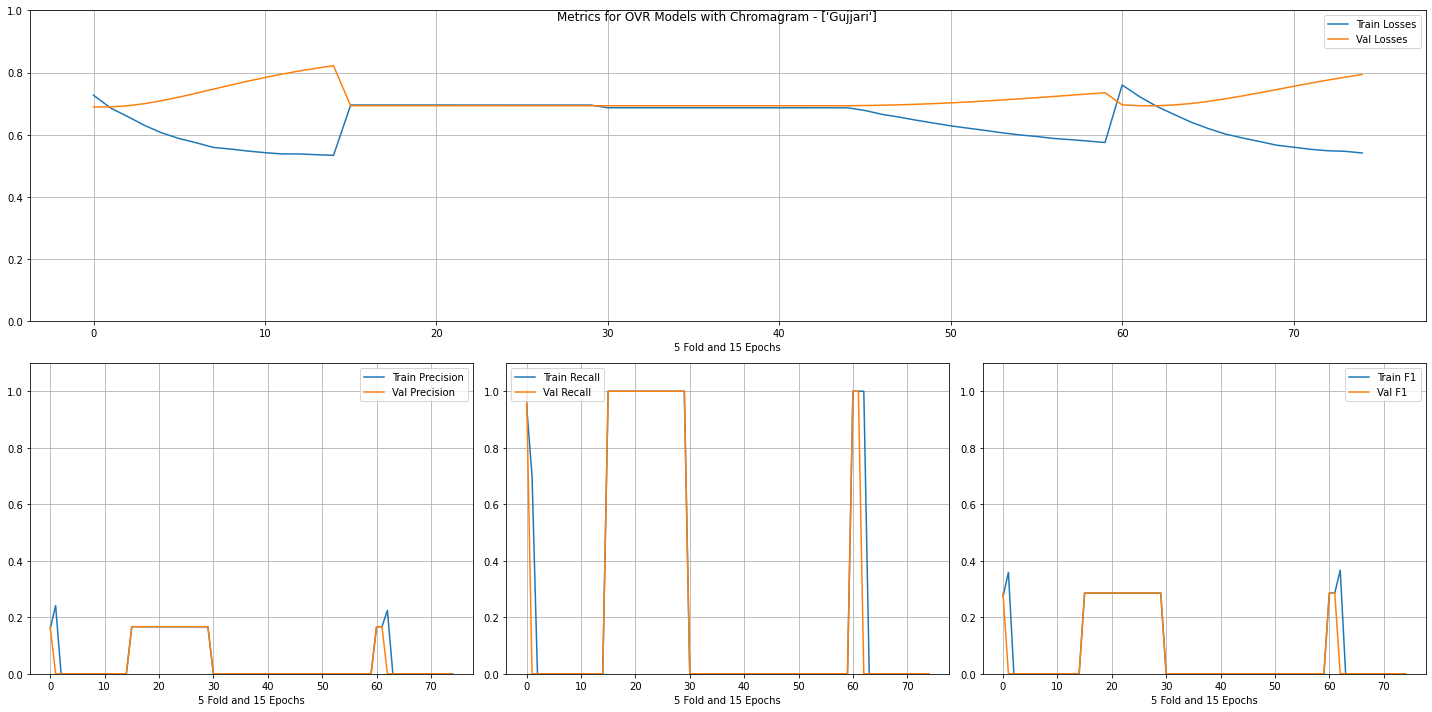

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.235294,0.166667,0.4,0.0,0.0,0.0,0.275701,0.179878,0.59


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.695563           0.693156
1   0.285714       0.285714  ...      0.695551           0.693156
2   0.285714       0.285714  ...      0.695541           0.693156
3   0.285714       0.285714  ...      0.695530           0.693156
4   0.285714       0.285714  ...      0.695520           0.693156
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.559789           0.755743
11  0.000000       0.000000  ...      0.553042           0.765997
12  0.000000       0.000000  ...      0.548448           0.775825
13  0.000000       0.000000  ...      0.546638           0.785037
14  0.000000       0.000000  ...      0.541180           0.793676

[75 rows x 12 columns]
Training for ['Gundukriya'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.720 / Validation Loss : 0.688 [Tim

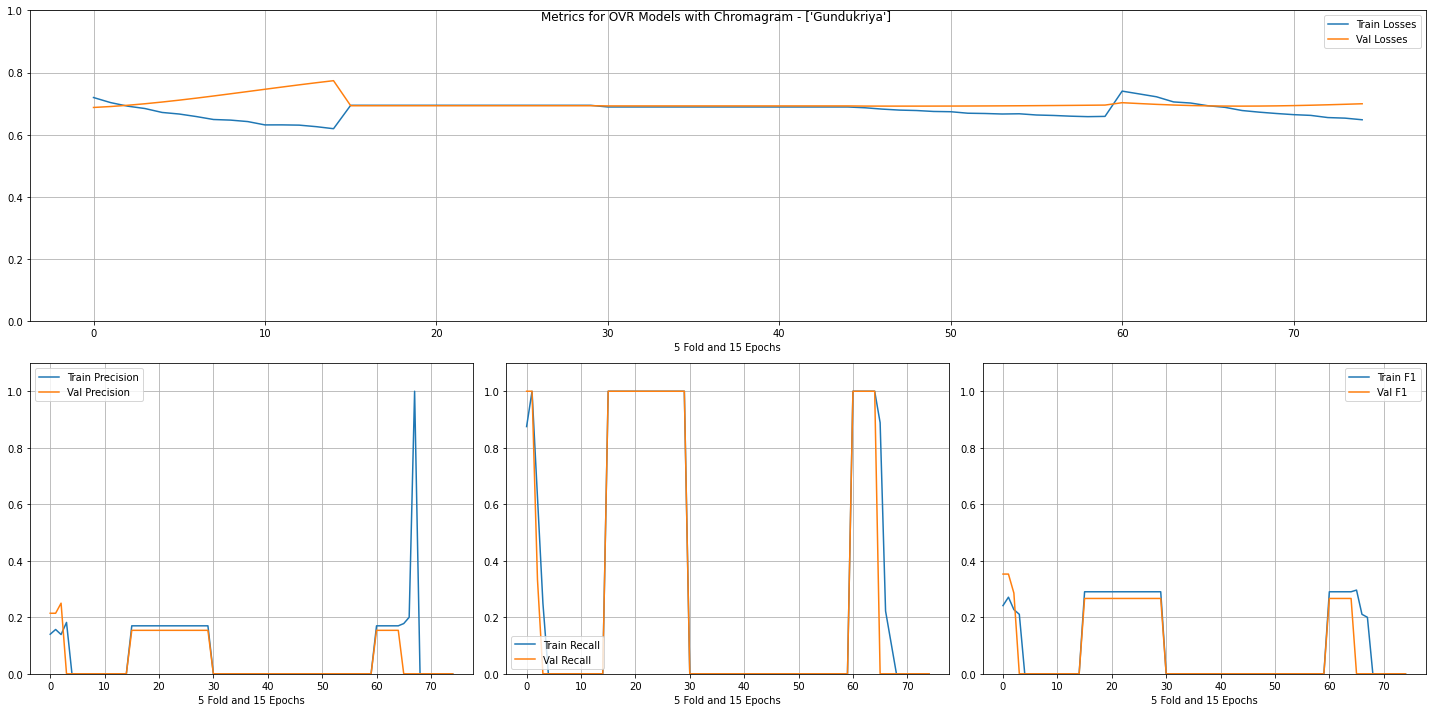

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.263158,0.185185,0.454545,0.0,0.0,0.0,0.22973,0.163462,0.386364


    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.271186       0.352941  ...      0.703291           0.690747
0   0.241379       0.352941  ...      0.719682           0.687704
2   0.227273       0.285714  ...      0.691822           0.694778
0   0.290323       0.266667  ...      0.694629           0.693363
1   0.290323       0.266667  ...      0.694625           0.693363
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.664577           0.693705
11  0.000000       0.000000  ...      0.662196           0.694893
12  0.000000       0.000000  ...      0.655189           0.696311
13  0.000000       0.000000  ...      0.653343           0.697909
14  0.000000       0.000000  ...      0.648128           0.699625

[75 rows x 12 columns]
Training for ['Kambodhi'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 235/59
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.732 / Validation Loss : 0.690 [Time

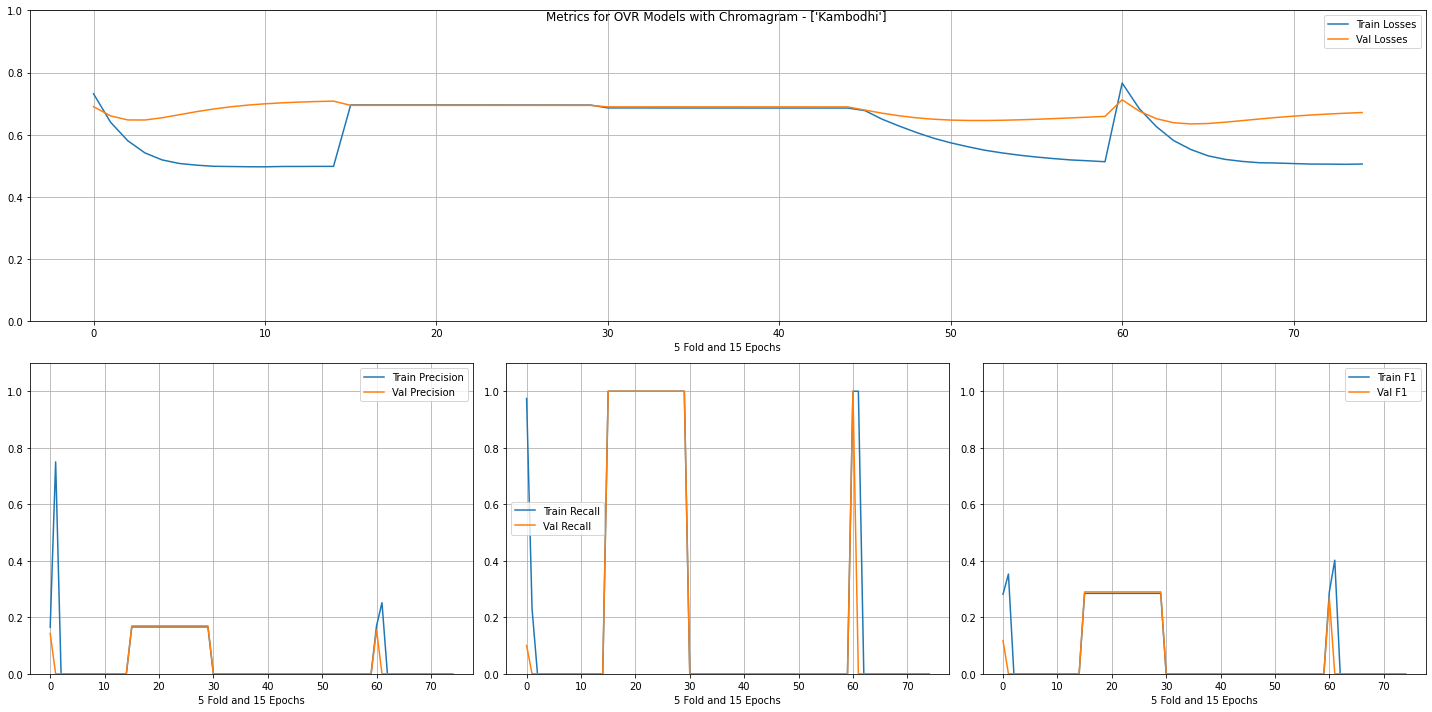

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.185185,0.169492,0.204082,0.0,0.0,0.0,0.180974,0.165957,0.19898


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.284672       0.289855  ...      0.695784           0.694479
1   0.284672       0.289855  ...      0.695756           0.694467
2   0.284672       0.289855  ...      0.695730           0.694454
3   0.284672       0.289855  ...      0.695705           0.694440
4   0.284672       0.289855  ...      0.695678           0.694427
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.507199           0.659738
11  0.000000       0.000000  ...      0.505606           0.663391
12  0.000000       0.000000  ...      0.505390           0.666477
13  0.000000       0.000000  ...      0.504771           0.669147
14  0.000000       0.000000  ...      0.505677           0.671416

[75 rows x 12 columns]
Training for ['Kannadagowla'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 336/84
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.729 / Validation Loss : 0.673 [

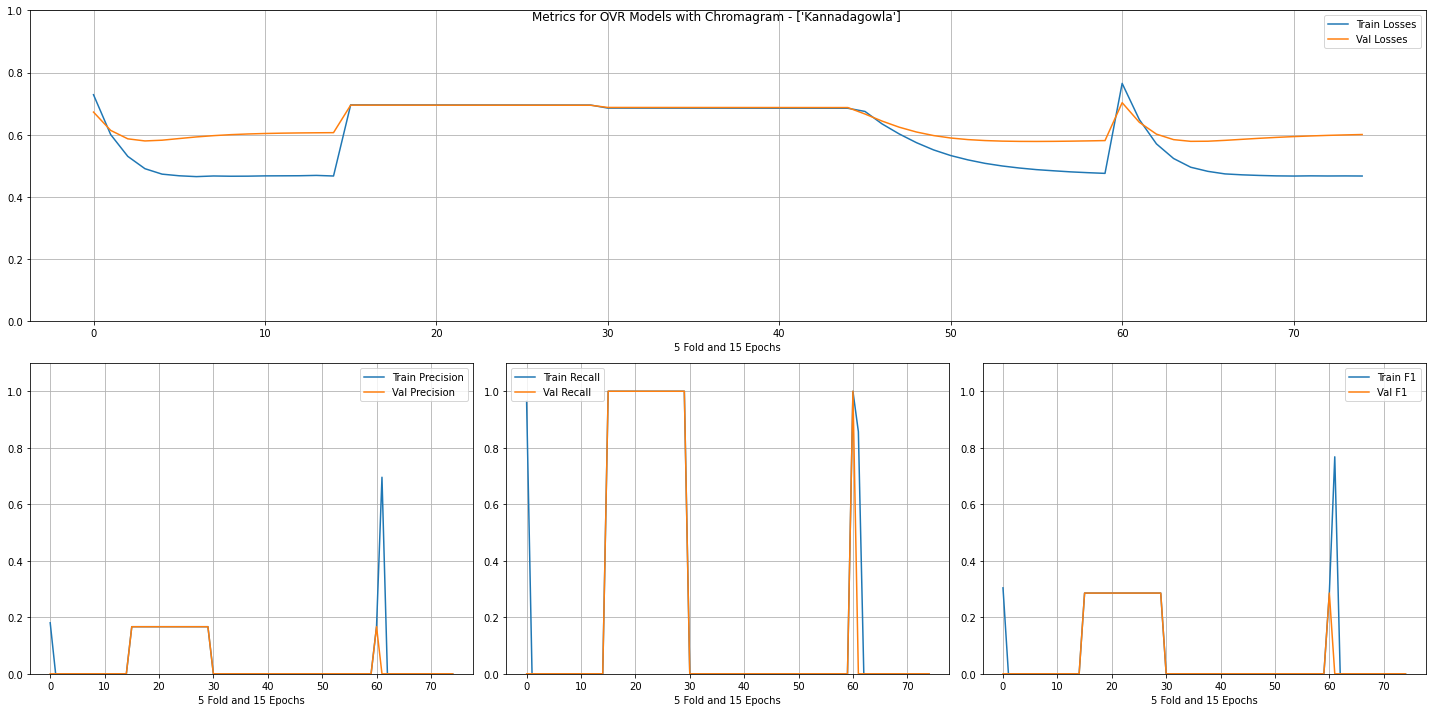

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.695972           0.695184
1   0.285714       0.285714  ...      0.695931           0.695158
2   0.285714       0.285714  ...      0.695892           0.695129
3   0.285714       0.285714  ...      0.695853           0.695101
4   0.285714       0.285714  ...      0.695814           0.695073
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.467047           0.593950
11  0.000000       0.000000  ...      0.467641           0.596069
12  0.000000       0.000000  ...      0.467236           0.597875
13  0.000000       0.000000  ...      0.467444           0.599381
14  0.000000       0.000000  ...      0.467136           0.600648

[75 rows x 12 columns]
Training for ['Lalitha'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 62/16
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.719 / Validation Loss : 0.694 [Time :

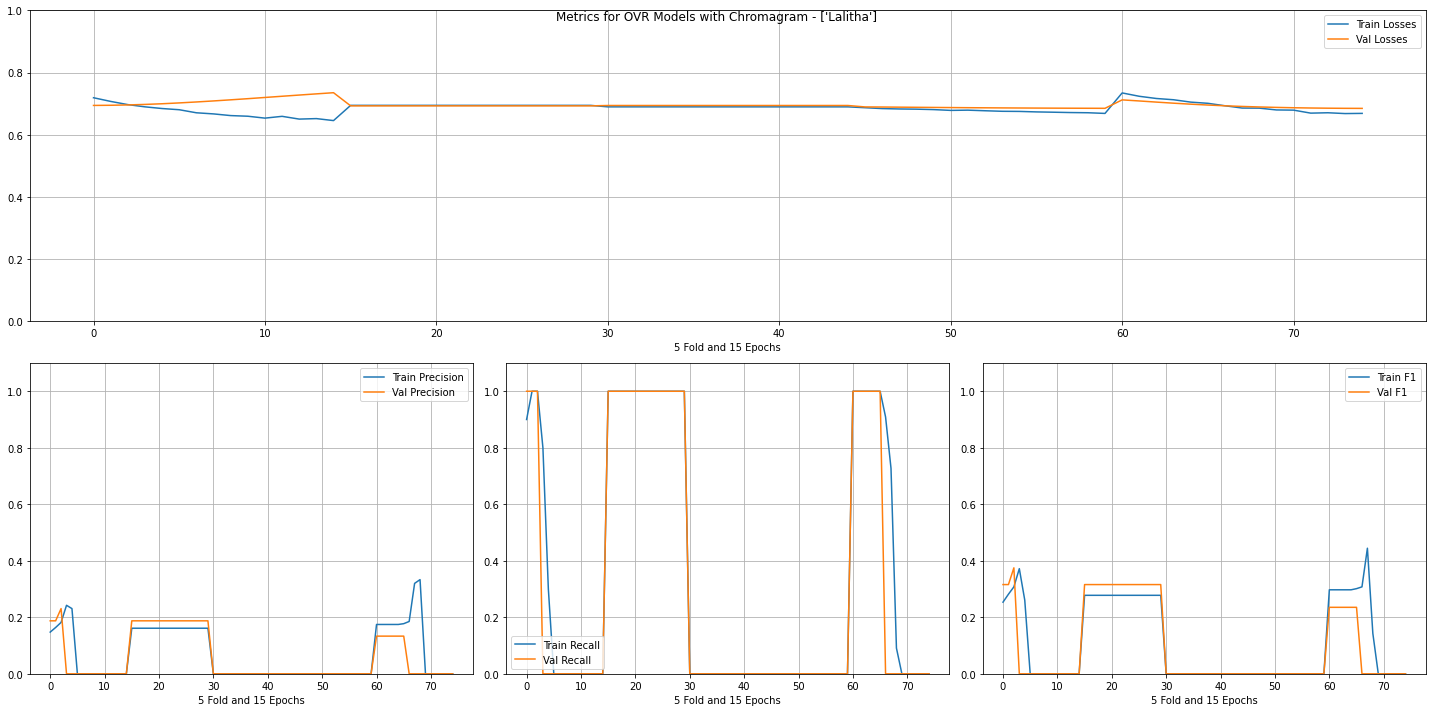

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.266667,0.1875,0.461538,0.0,0.0,0.0,0.217143,0.154472,0.365385


    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.307692       0.375000  ...      0.696901           0.695842
1   0.281690       0.315789  ...      0.707184           0.694741
0   0.277778       0.315789  ...      0.694487           0.692846
1   0.277778       0.315789  ...      0.694483           0.692847
2   0.277778       0.315789  ...      0.694481           0.692847
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.679091           0.686784
11  0.000000       0.000000  ...      0.669455           0.685946
12  0.000000       0.000000  ...      0.670665           0.685337
13  0.000000       0.000000  ...      0.668067           0.684928
14  0.000000       0.000000  ...      0.668643           0.684736

[75 rows x 12 columns]
Training for ['Maalavi'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 153/39
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.724 / Validation Loss : 0.698 [Time 

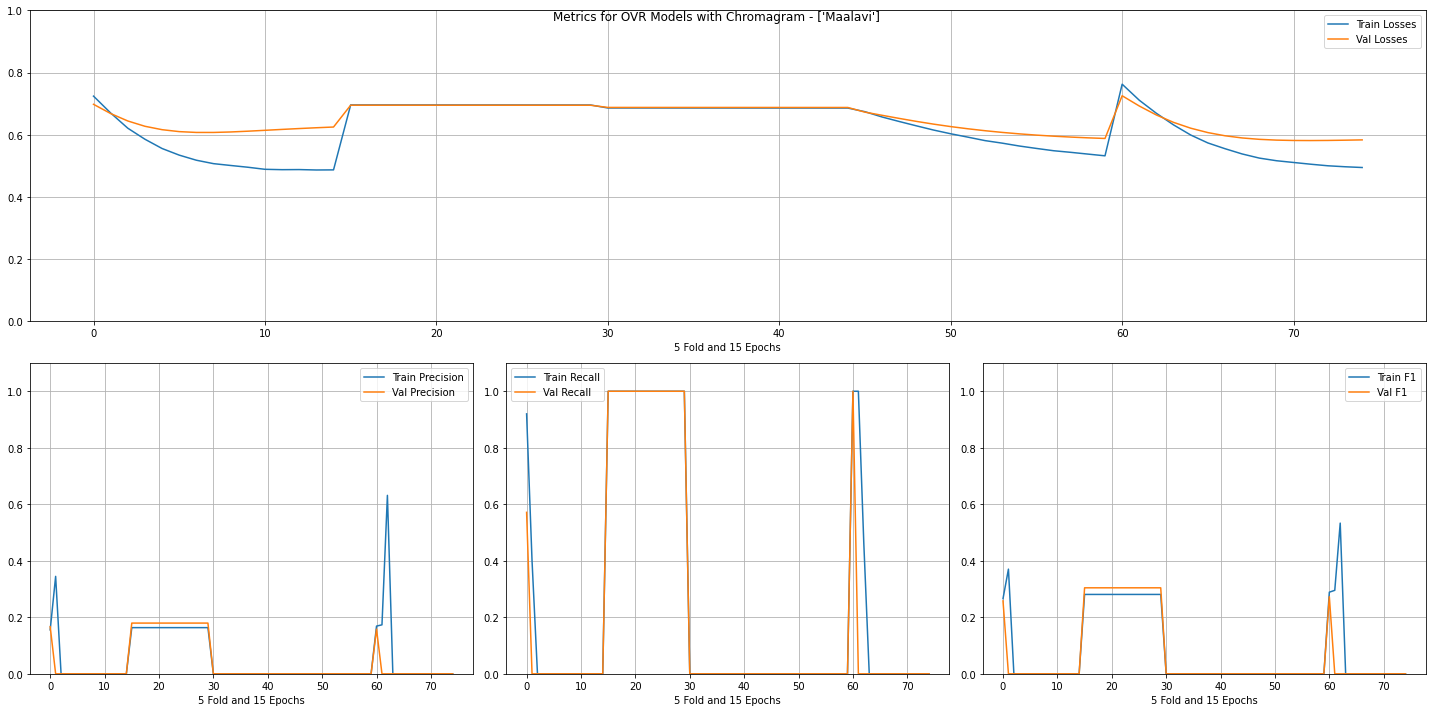

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.197183,0.179487,0.21875,0.0,0.0,0.0,0.177936,0.163399,0.195312


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.280899       0.304348  ...      0.695855           0.694961
1   0.280899       0.304348  ...      0.695838           0.694951
2   0.280899       0.304348  ...      0.695822           0.694940
3   0.280899       0.304348  ...      0.695806           0.694930
4   0.280899       0.304348  ...      0.695790           0.694919
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.510687           0.581495
11  0.000000       0.000000  ...      0.505084           0.581254
12  0.000000       0.000000  ...      0.500061           0.581622
13  0.000000       0.000000  ...      0.496930           0.582391
14  0.000000       0.000000  ...      0.494486           0.583372

[75 rows x 12 columns]
Training for ['Malahari'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 129/33
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.715 / Validation Loss : 0.691 [Time

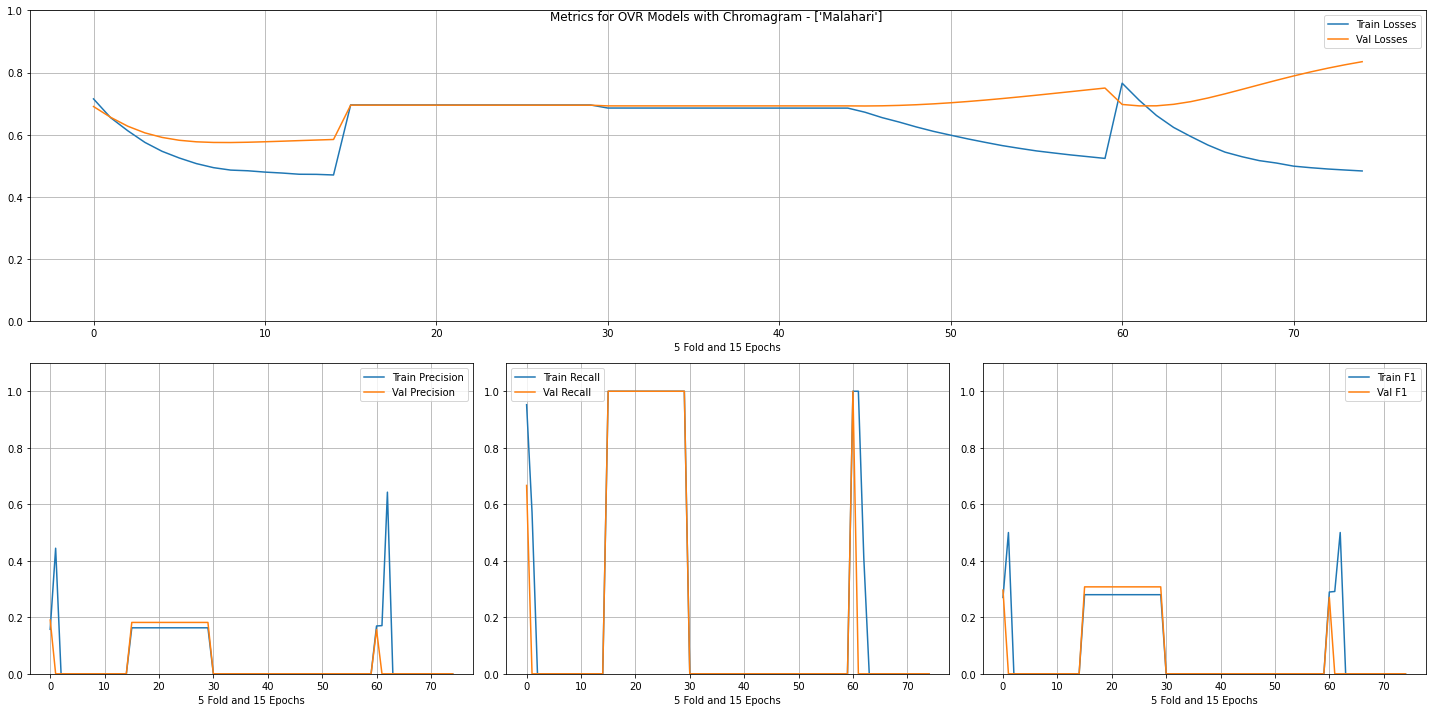

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.2,0.181818,0.222222,0.0,0.0,0.0,0.234973,0.166667,0.398148


    train_f1  validation_f1  ...  train_losses  validation_losses
0       0.28       0.307692  ...      0.695927           0.695166
1       0.28       0.307692  ...      0.695909           0.695155
2       0.28       0.307692  ...      0.695892           0.695142
3       0.28       0.307692  ...      0.695875           0.695129
4       0.28       0.307692  ...      0.695858           0.695117
..       ...            ...  ...           ...                ...
10      0.00       0.000000  ...      0.498877           0.789072
11      0.00       0.000000  ...      0.493843           0.802133
12      0.00       0.000000  ...      0.489685           0.814153
13      0.00       0.000000  ...      0.486448           0.825076
14      0.00       0.000000  ...      0.483373           0.834973

[75 rows x 12 columns]
Training for ['Malavigowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.726 / Validation Loss : 0.690 [Ti

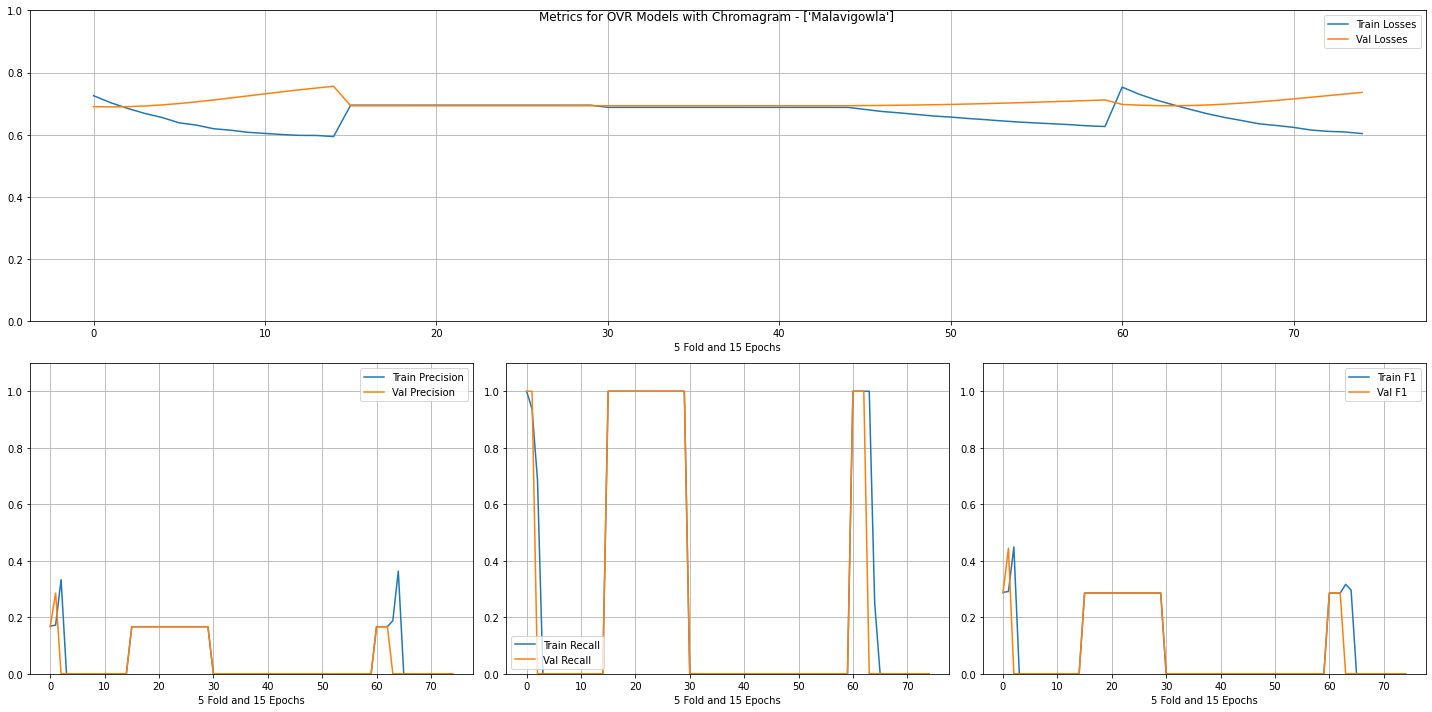

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.275862,0.210526,0.4,0.0,0.0,0.0,0.270115,0.175373,0.5875


    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.291262       0.444444  ...      0.703006           0.689614
0   0.288288       0.285714  ...      0.725591           0.690304
0   0.285714       0.285714  ...      0.695090           0.693156
1   0.285714       0.285714  ...      0.695083           0.693157
2   0.285714       0.285714  ...      0.695078           0.693157
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.623609           0.715341
11  0.000000       0.000000  ...      0.615157           0.720444
12  0.000000       0.000000  ...      0.610872           0.725678
13  0.000000       0.000000  ...      0.608844           0.730923
14  0.000000       0.000000  ...      0.603663           0.736104

[75 rows x 12 columns]
Training for ['Mukhari'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.726 / Validation Loss : 0.690 [Time :

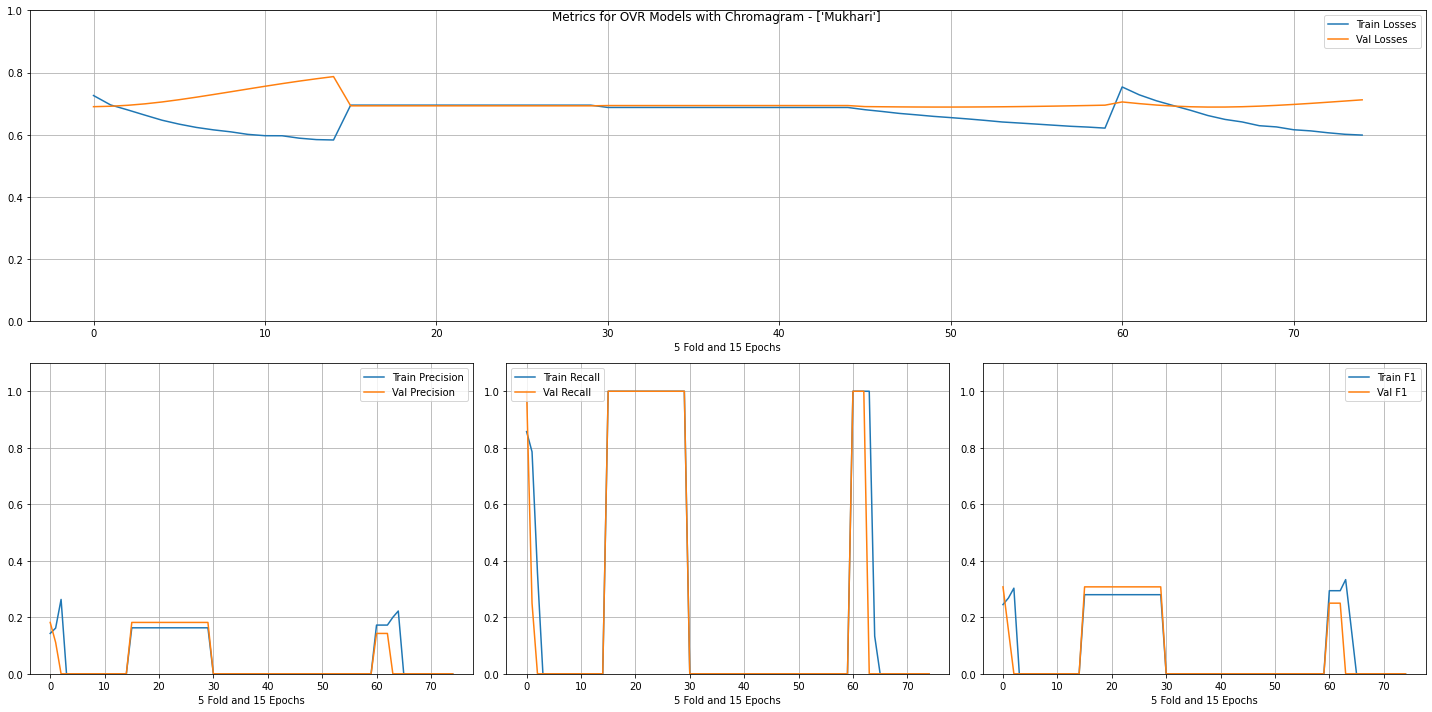

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.258065,0.181818,0.444444,0.0,0.0,0.0,0.214876,0.152941,0.361111


    train_f1  validation_f1  ...  train_losses  validation_losses
0       0.28       0.307692  ...      0.695199           0.692928
1       0.28       0.307692  ...      0.695192           0.692928
2       0.28       0.307692  ...      0.695186           0.692929
3       0.28       0.307692  ...      0.695180           0.692930
4       0.28       0.307692  ...      0.695174           0.692931
..       ...            ...  ...           ...                ...
10      0.00       0.000000  ...      0.616027           0.697435
11      0.00       0.000000  ...      0.612329           0.700853
12      0.00       0.000000  ...      0.606282           0.704564
13      0.00       0.000000  ...      0.601356           0.708396
14      0.00       0.000000  ...      0.598843           0.712287

[75 rows x 12 columns]
Training for ['Naata'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.728 / Validation Loss : 0.695 [Time : 0

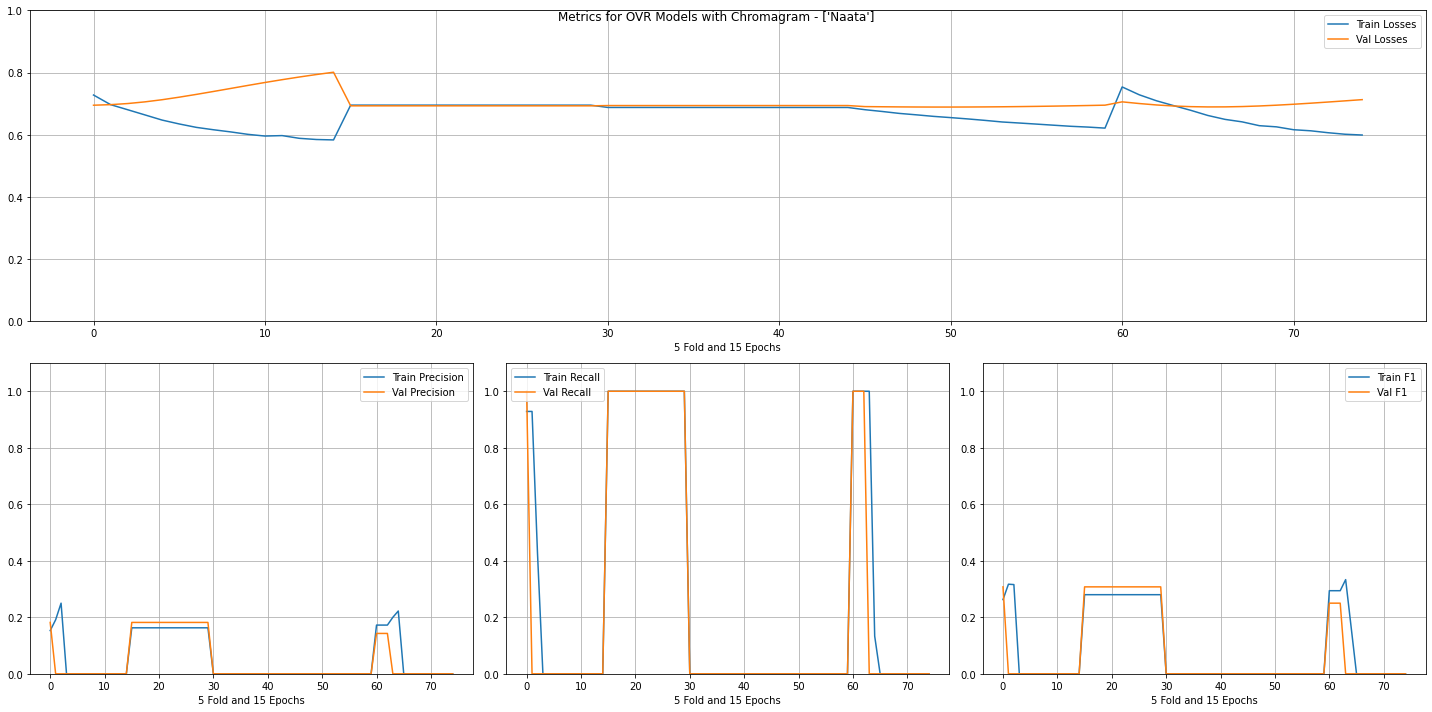

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.258065,0.181818,0.444444,0.0,0.0,0.0,0.222222,0.157895,0.375


    train_f1  validation_f1  ...  train_losses  validation_losses
0       0.28       0.307692  ...      0.695199           0.692928
1       0.28       0.307692  ...      0.695192           0.692928
2       0.28       0.307692  ...      0.695186           0.692929
3       0.28       0.307692  ...      0.695180           0.692930
4       0.28       0.307692  ...      0.695174           0.692931
..       ...            ...  ...           ...                ...
10      0.00       0.000000  ...      0.616093           0.698040
11      0.00       0.000000  ...      0.612620           0.701463
12      0.00       0.000000  ...      0.606491           0.705132
13      0.00       0.000000  ...      0.601535           0.708968
14      0.00       0.000000  ...      0.599032           0.712857

[75 rows x 12 columns]
Training for ['Nadaramakriya'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 264/66
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.734 / Validation Loss : 0.686 

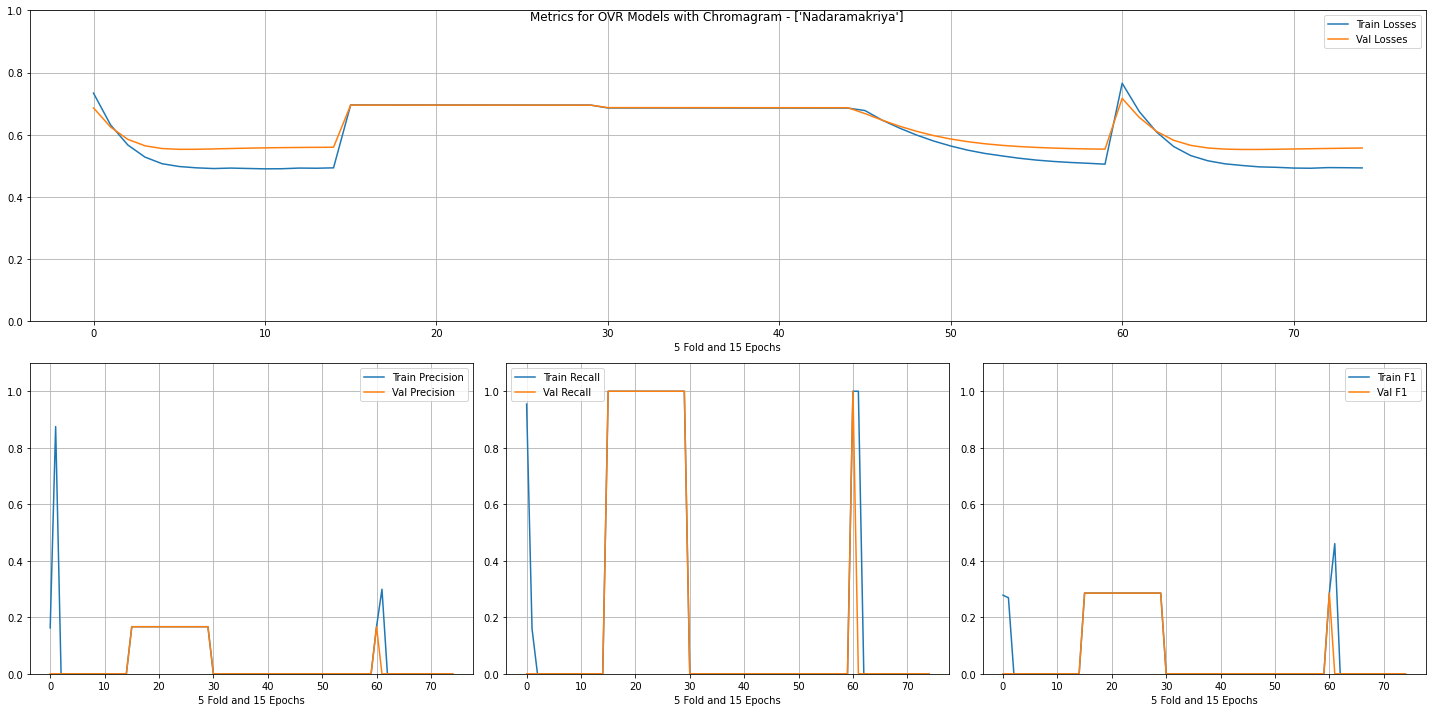

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.695814           0.695395
1   0.285714       0.285714  ...      0.695783           0.695372
2   0.285714       0.285714  ...      0.695754           0.695348
3   0.285714       0.285714  ...      0.695725           0.695323
4   0.285714       0.285714  ...      0.695696           0.695298
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.492721           0.554083
11  0.000000       0.000000  ...      0.492160           0.554957
12  0.000000       0.000000  ...      0.494229           0.555778
13  0.000000       0.000000  ...      0.493861           0.556523
14  0.000000       0.000000  ...      0.493172           0.557178

[75 rows x 12 columns]
Training for ['Paadi'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.731 / Validation Loss : 0.676 [Time : 

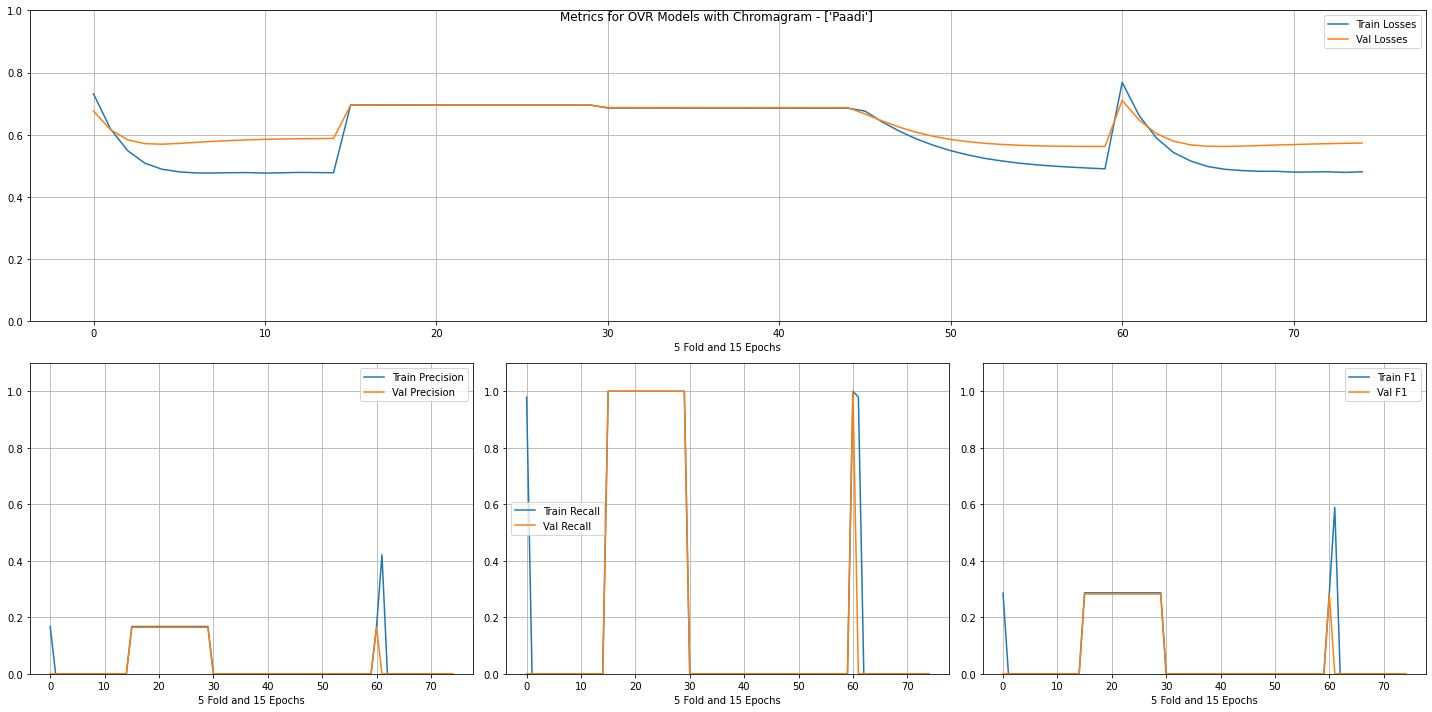

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.179104,0.164384,0.196721,0.0,0.0,0.0,0.182495,0.167235,0.20082


    train_f1  validation_f1  ...  train_losses  validation_losses
0    0.28655       0.282353  ...      0.695896           0.695317
1    0.28655       0.282353  ...      0.695860           0.695292
2    0.28655       0.282353  ...      0.695826           0.695265
3    0.28655       0.282353  ...      0.695792           0.695238
4    0.28655       0.282353  ...      0.695758           0.695211
..       ...            ...  ...           ...                ...
10   0.00000       0.000000  ...      0.479603           0.568473
11   0.00000       0.000000  ...      0.480187           0.569951
12   0.00000       0.000000  ...      0.480747           0.571215
13   0.00000       0.000000  ...      0.478820           0.572314
14   0.00000       0.000000  ...      0.480879           0.573223

[75 rows x 12 columns]
Training for ['Ramakriya'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 470/118
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.735 / Validation Loss : 0.655 [Ti

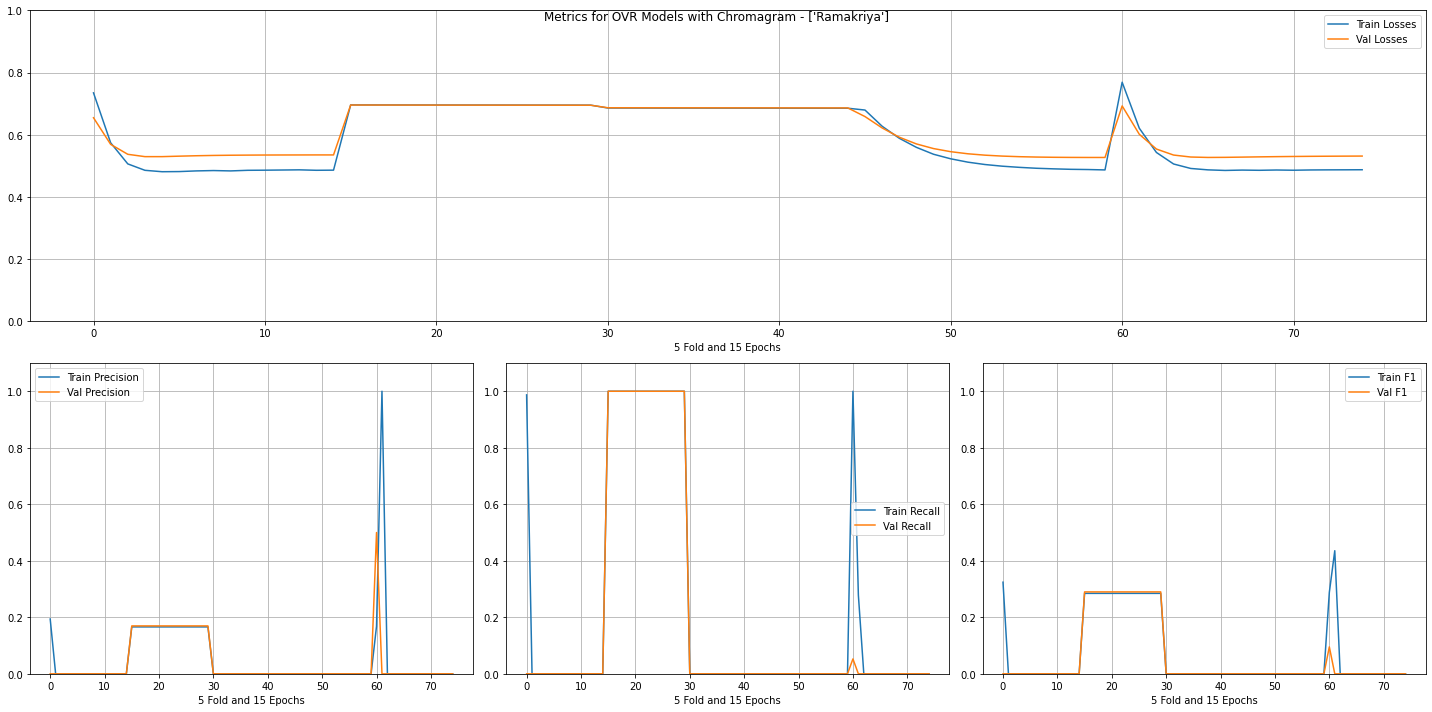

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.185185,0.169492,0.204082,0.0,0.0,0.0,0.180974,0.165957,0.19898


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.284672       0.289855  ...      0.695886           0.695543
1   0.284672       0.289855  ...      0.695831           0.695500
2   0.284672       0.289855  ...      0.695781           0.695456
3   0.284672       0.289855  ...      0.695730           0.695411
4   0.284672       0.289855  ...      0.695680           0.695366
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.485746           0.530028
11  0.000000       0.000000  ...      0.486616           0.530475
12  0.000000       0.000000  ...      0.486941           0.530820
13  0.000000       0.000000  ...      0.487097           0.531085
14  0.000000       0.000000  ...      0.487320           0.531302

[75 rows x 12 columns]
Training for ['Salangam'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 105/27
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.727 / Validation Loss : 0.687 [Time

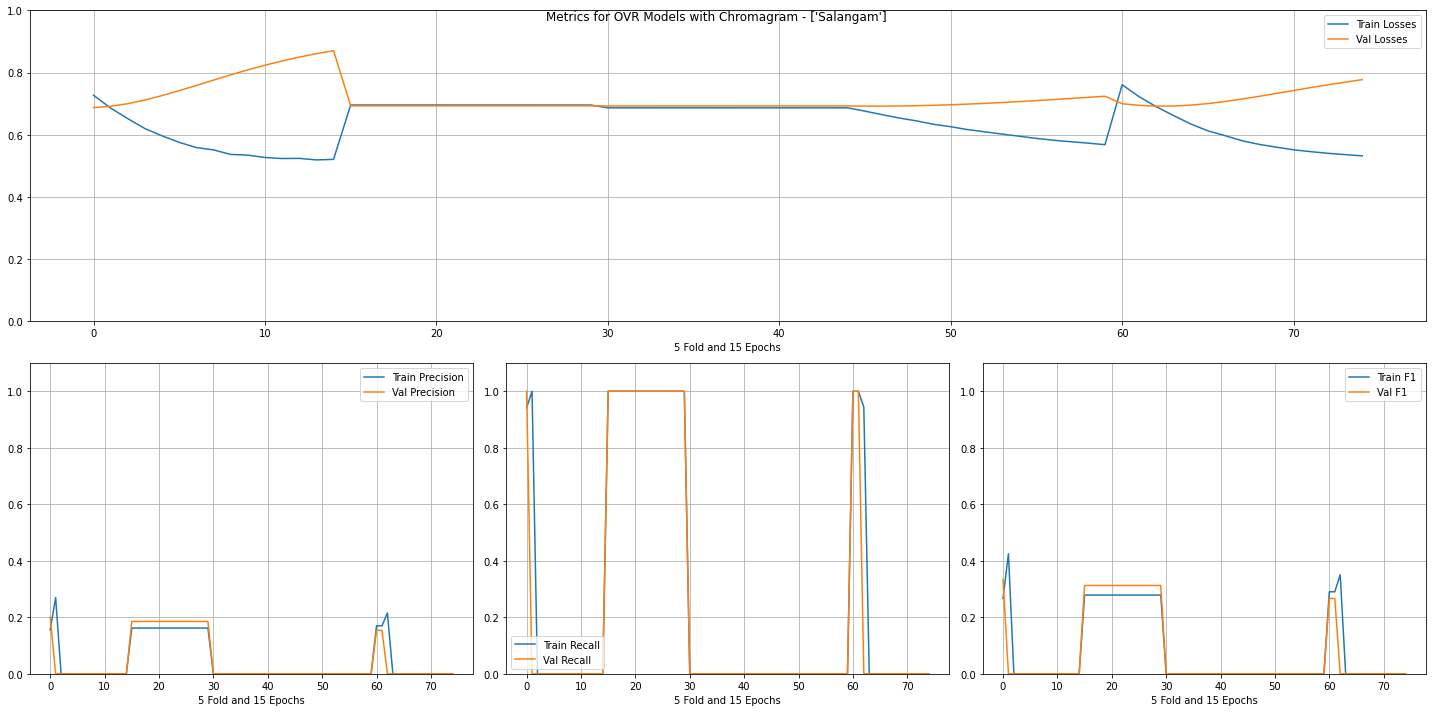

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.27027,0.192308,0.454545,0.0,0.0,0.0,0.266667,0.174216,0.568182


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.266667       0.333333  ...      0.726979           0.687282
0   0.278689       0.312500  ...      0.695655           0.692880
1   0.278689       0.312500  ...      0.695643           0.692881
2   0.278689       0.312500  ...      0.695632           0.692882
3   0.278689       0.312500  ...      0.695620           0.692883
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.551507           0.742300
11  0.000000       0.000000  ...      0.545480           0.751625
12  0.000000       0.000000  ...      0.540223           0.760609
13  0.000000       0.000000  ...      0.536028           0.769149
14  0.000000       0.000000  ...      0.531942           0.777214

[75 rows x 12 columns]
Training for ['Salanganata'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 326/82
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.729 / Validation Loss : 0.673 [T

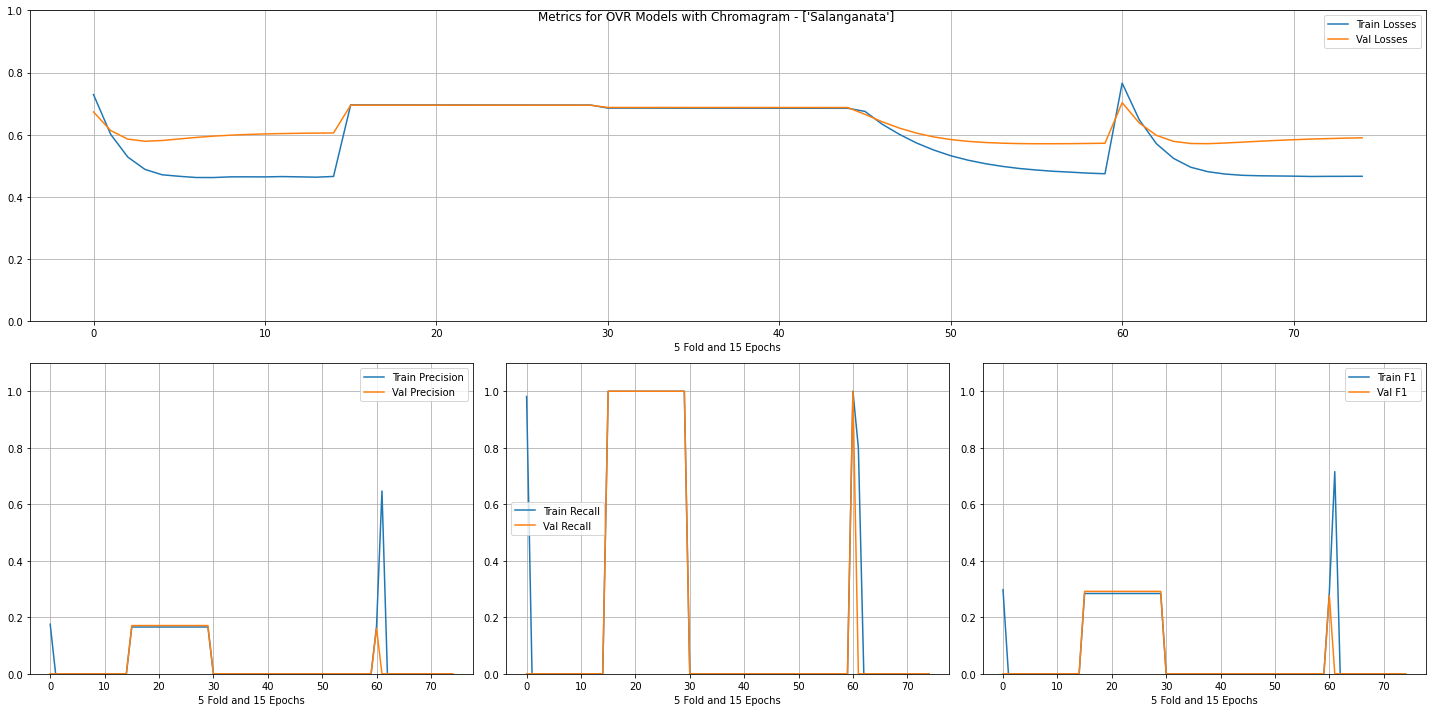

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.186667,0.170732,0.205882,0.0,0.0,0.0,0.180602,0.165644,0.198529


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.284211       0.291667  ...      0.695988           0.695184
1   0.284211       0.291667  ...      0.695947           0.695157
2   0.284211       0.291667  ...      0.695907           0.695129
3   0.284211       0.291667  ...      0.695868           0.695100
4   0.284211       0.291667  ...      0.695828           0.695071
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.466701           0.583951
11  0.000000       0.000000  ...      0.465687           0.585917
12  0.000000       0.000000  ...      0.466044           0.587566
13  0.000000       0.000000  ...      0.466151           0.588960
14  0.000000       0.000000  ...      0.466266           0.590110

[75 rows x 12 columns]
Training for ['Samantham'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 158/40
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.725 / Validation Loss : 0.696 [Tim

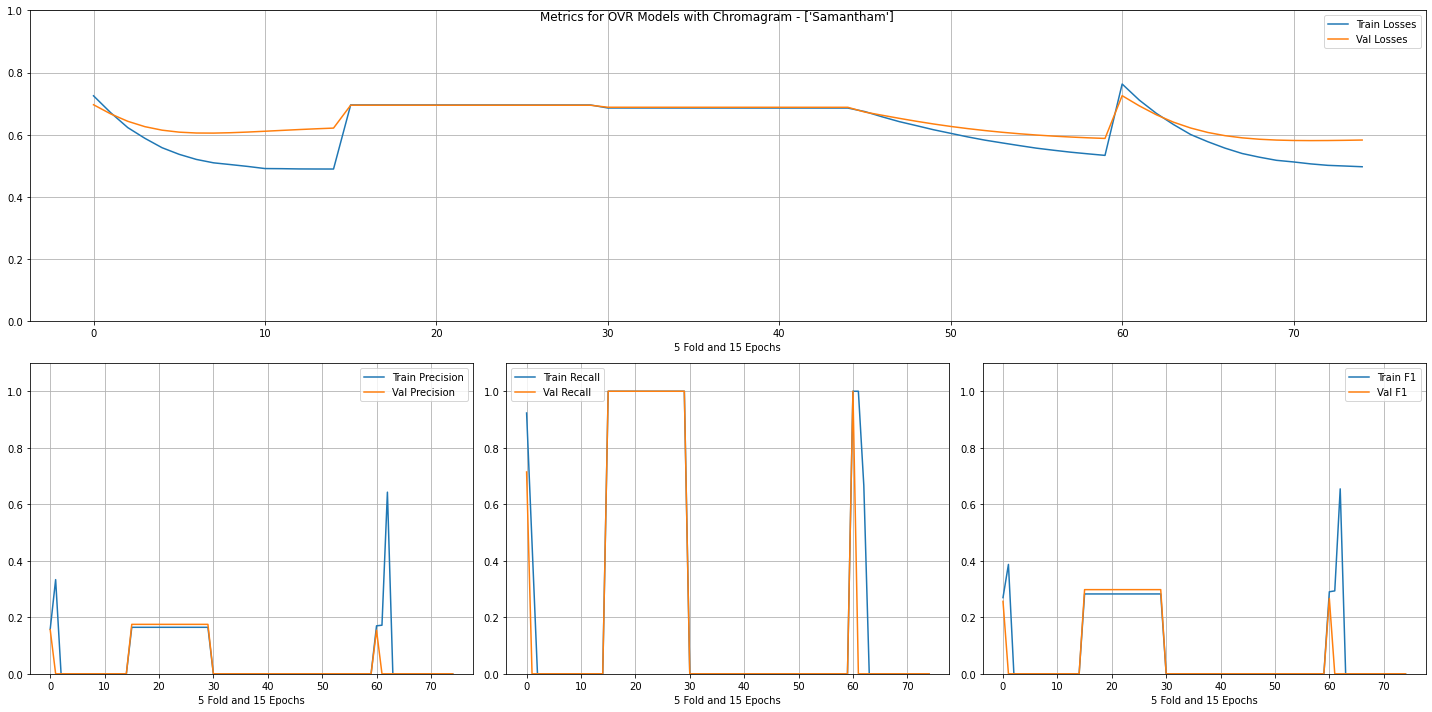

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.191781,0.175,0.212121,0.0,0.0,0.0,0.17931,0.164557,0.19697


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.282609       0.297872  ...      0.695840           0.694961
1   0.282609       0.297872  ...      0.695823           0.694951
2   0.282609       0.297872  ...      0.695808           0.694941
3   0.282609       0.297872  ...      0.695792           0.694930
4   0.282609       0.297872  ...      0.695776           0.694919
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.512389           0.581471
11  0.000000       0.000000  ...      0.506112           0.581085
12  0.000000       0.000000  ...      0.501443           0.581335
13  0.000000       0.000000  ...      0.499269           0.581999
14  0.000000       0.000000  ...      0.496954           0.582897

[75 rows x 12 columns]
Training for ['Sankarabharanam'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 312/78
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.734 / Validation Loss : 0.68

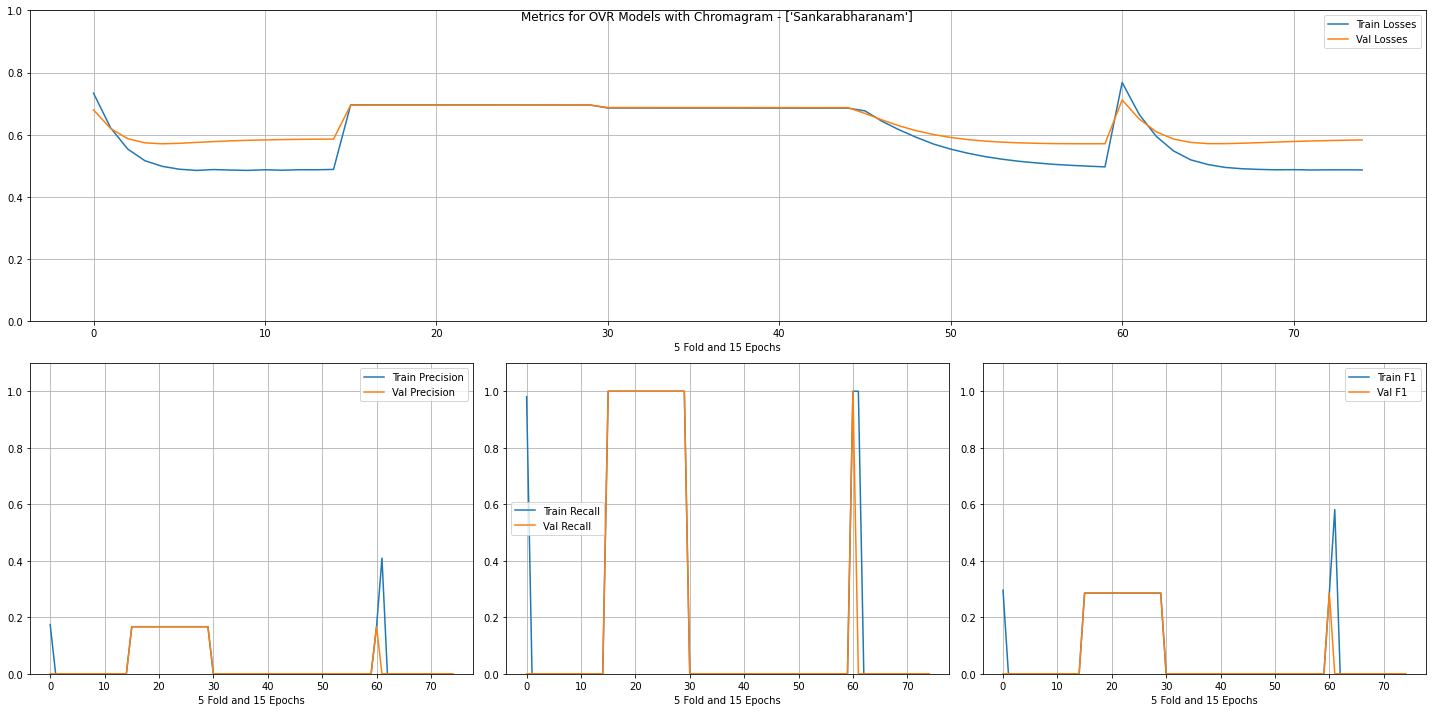

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.181818,0.166667,0.2,0.0,0.0,0.0,0.181818,0.166667,0.2


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285714       0.285714  ...      0.695859           0.695249
1   0.285714       0.285714  ...      0.695824           0.695225
2   0.285714       0.285714  ...      0.695792           0.695200
3   0.285714       0.285714  ...      0.695759           0.695175
4   0.285714       0.285714  ...      0.695726           0.695149
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.487629           0.578183
11  0.000000       0.000000  ...      0.486536           0.579790
12  0.000000       0.000000  ...      0.486996           0.581141
13  0.000000       0.000000  ...      0.487158           0.582286
14  0.000000       0.000000  ...      0.486598           0.583229

[75 rows x 12 columns]
Training for ['Sriragam'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 427/107
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.734 / Validation Loss : 0.658 [Tim

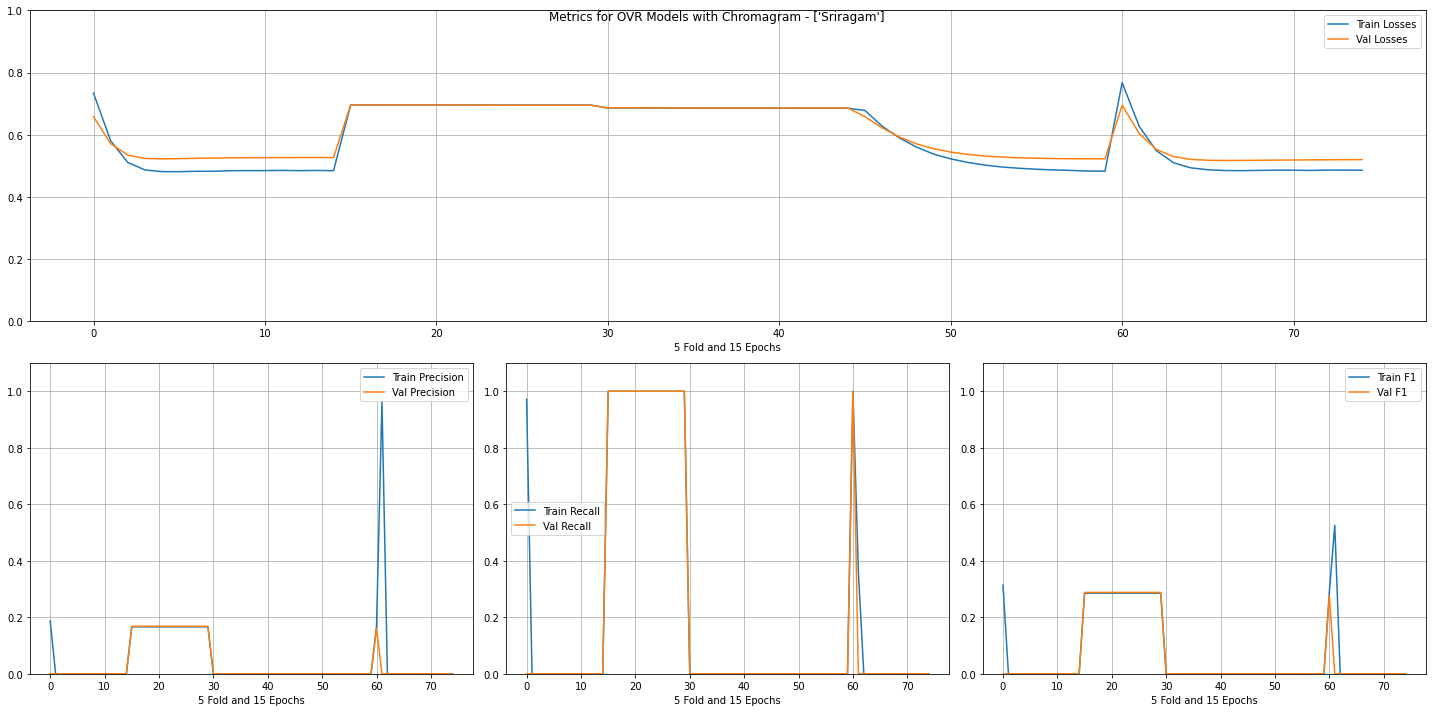

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.183673,0.168224,0.202247,0.0,0.0,0.0,0.181354,0.166276,0.199438


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285141          0.288  ...      0.695901           0.695603
1   0.285141          0.288  ...      0.695849           0.695561
2   0.285141          0.288  ...      0.695801           0.695518
3   0.285141          0.288  ...      0.695752           0.695474
4   0.285141          0.288  ...      0.695704           0.695430
..       ...            ...  ...           ...                ...
10  0.000000          0.000  ...      0.485812           0.518746
11  0.000000          0.000  ...      0.485118           0.519122
12  0.000000          0.000  ...      0.486221           0.519422
13  0.000000          0.000  ...      0.486270           0.519659
14  0.000000          0.000  ...      0.485634           0.519847

[75 rows x 12 columns]
Training for ['Suddavasantham'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.717 / Validation Loss : 0.685 

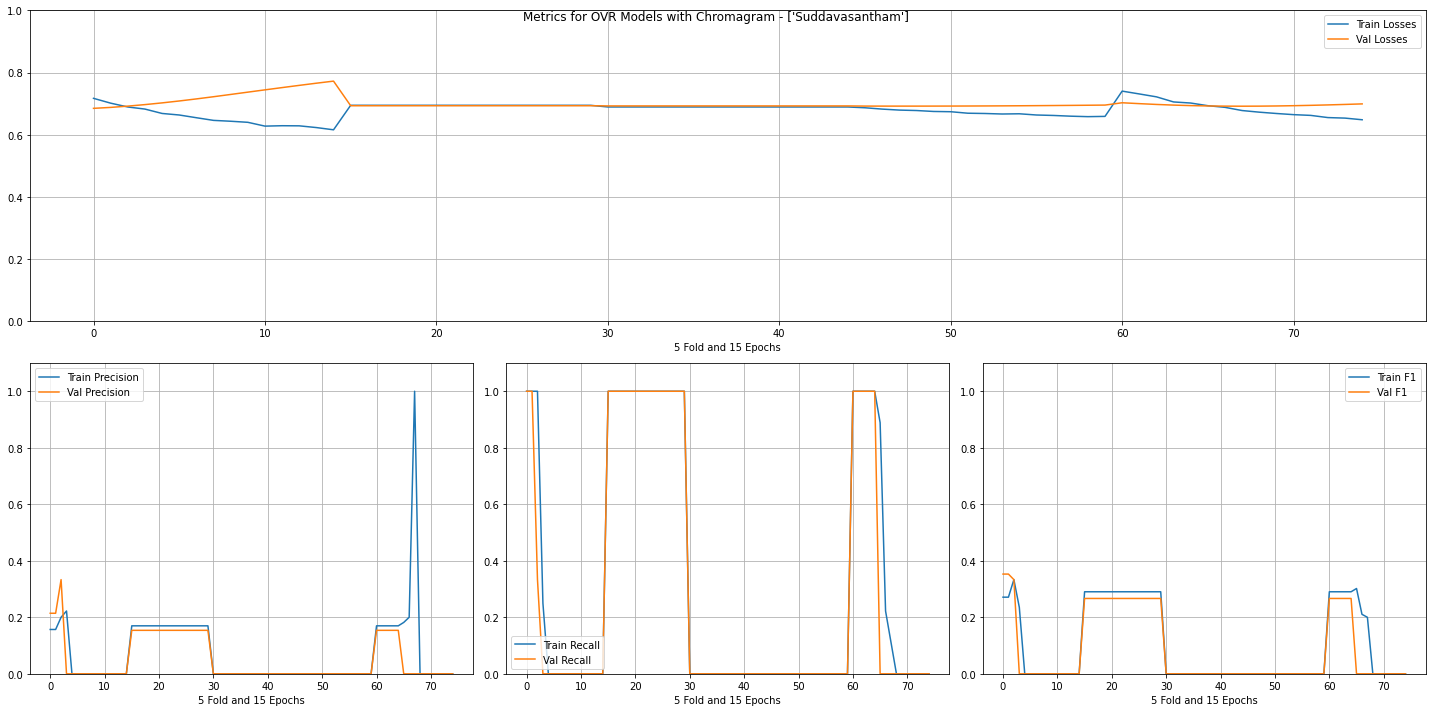

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.263158,0.185185,0.454545,0.0,0.0,0.0,0.241611,0.171429,0.409091


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.271186       0.352941  ...      0.717084           0.684859
1   0.271186       0.352941  ...      0.701547           0.687900
2   0.333333       0.333333  ...      0.689240           0.691986
0   0.290323       0.266667  ...      0.694629           0.693363
1   0.290323       0.266667  ...      0.694625           0.693363
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.664589           0.693397
11  0.000000       0.000000  ...      0.662179           0.694513
12  0.000000       0.000000  ...      0.655157           0.695894
13  0.000000       0.000000  ...      0.653450           0.697463
14  0.000000       0.000000  ...      0.648162           0.699181

[75 rows x 12 columns]
Training for ['Varali'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 451/113
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 0.733 / Validation Loss : 0.652 [Time 

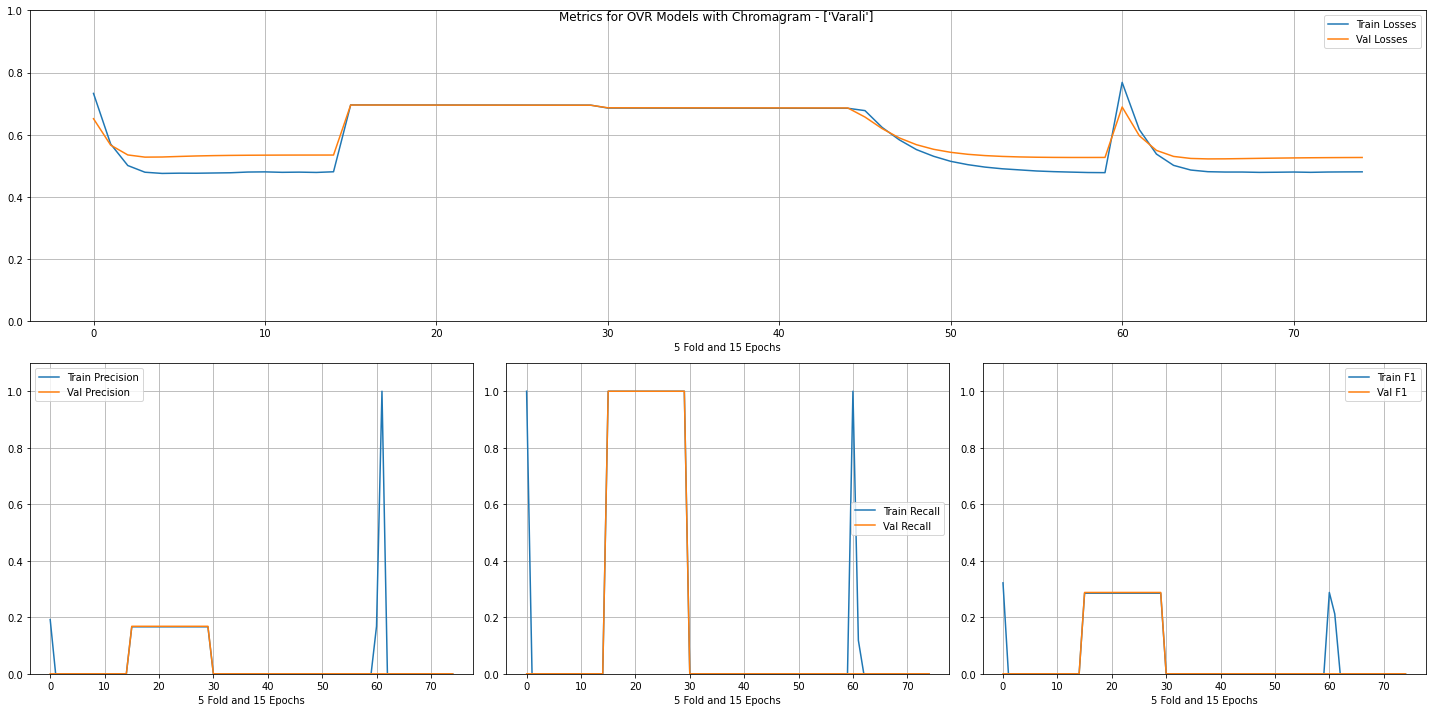

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.183575,0.168142,0.202128,0.0,0.0,0.0,0.181378,0.166297,0.199468


    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.285171       0.287879  ...      0.695926           0.695570
1   0.285171       0.287879  ...      0.695870           0.695526
2   0.285171       0.287879  ...      0.695818           0.695480
3   0.285171       0.287879  ...      0.695765           0.695434
4   0.285171       0.287879  ...      0.695713           0.695387
..       ...            ...  ...           ...                ...
10  0.000000       0.000000  ...      0.479965           0.525367
11  0.000000       0.000000  ...      0.478966           0.525886
12  0.000000       0.000000  ...      0.479980           0.526261
13  0.000000       0.000000  ...      0.480335           0.526552
14  0.000000       0.000000  ...      0.480579           0.526762

[75 rows x 12 columns]


In [10]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, ChromaMatrixDataset, ChromaRaga, "OVR Models with Chromagram", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-6 , epochs=15, n_folds=5, feature='chroma',nindex_factor=5)

In [11]:
tab = pd.DataFrame(columns=['Raga','Train Confusion','Test Confusion'] + list(ovr_res[list(ovr_res.keys())[0]][1].keys()))
idx = 0
nresults = 1
for r in ovr_res:
  # Get top "nresults"
  tmp = results_to_df(ovr_res[r]).head(nresults)
  for _ in range(nresults):
    tab.loc[idx,'Raga'] = le.inverse_transform([r])[0]
    for i in tmp.columns:
      tab.loc[idx,i] = tmp[i].tolist()[_]
    t = confusion_matrix(tab.loc[idx,'train_labels'][0],tab.loc[idx,'train_predictions'][0])
    tab.loc[idx,'Train Confusion'] = str(t[0]) + '\n' +str(t[1])
    t = confusion_matrix(tab.loc[idx,'validation_labels'][0],tab.loc[idx,'validation_predictions'][0])
    tab.loc[idx,'Test Confusion'] = str(t[0]) + '\n' +str(t[1])
    idx = idx + 1

In [12]:
from IPython.display import display, HTML
display( HTML( tab[['Raga','Train Confusion','Test Confusion','train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']].to_html().replace("\\n","<br>") ) )

,Raga,Train Confusion,Test Confusion,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
0,Aahiri,[ 4 176][ 2 34],[36 9][3 6],0.276423,0.5,0.161905,0.4,0.944444,0.666667
1,Bauli,[ 0 60][ 0 12],[ 0 15][0 3],0.285714,0.285714,0.166667,0.166667,1,1
2,Bauliramakriya,[12 64][ 1 14],[13 6][1 3],0.301075,0.461538,0.179487,0.333333,0.933333,0.75
3,Bhairavi,[ 0 112][ 0 22],[ 0 28][0 6],0.282051,0.3,0.164179,0.176471,1,1
4,Bhupalam,[ 1 59][ 0 12],[ 0 15][0 3],0.289157,0.285714,0.169014,0.166667,1,1
5,Desakshi,[ 5 51][ 0 11],[13 1][2 1],0.30137,0.4,0.177419,0.5,1,0.333333
6,Desalam,[ 0 140][ 0 28],[ 0 35][0 7],0.285714,0.285714,0.166667,0.166667,1,1
7,Devagandhari,[ 0 116][ 0 23],[ 0 29][0 6],0.283951,0.292683,0.165468,0.171429,1,1
8,Dhannasi,[ 0 160][ 0 32],[ 0 40][0 8],0.285714,0.285714,0.166667,0.166667,1,1
9,Gowla,[ 1 79][ 0 16],[ 0 20][0 4],0.288288,0.285714,0.168421,0.166667,1,1


In [13]:
tab.index = tab['Raga']

In [14]:
def bar_plot(df, cols, title):
  df[cols].plot.bar(figsize=[20,5],grid=True)
  plt.title(title)
  plt.legend(['Train','Validation'])
  plt.xticks(rotation=45)
  plt.ylim([0,1])
  plt.show()

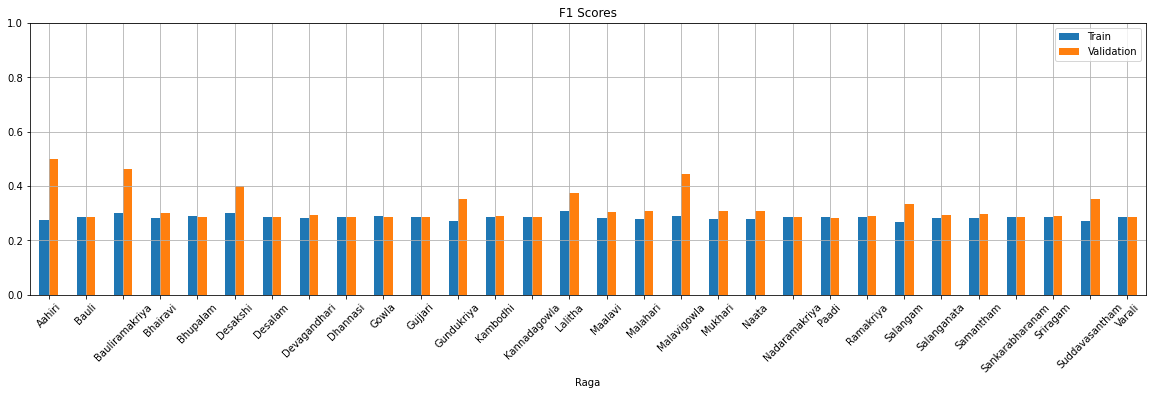

In [15]:
bar_plot(tab, ['train_f1','validation_f1'],'F1 Scores')

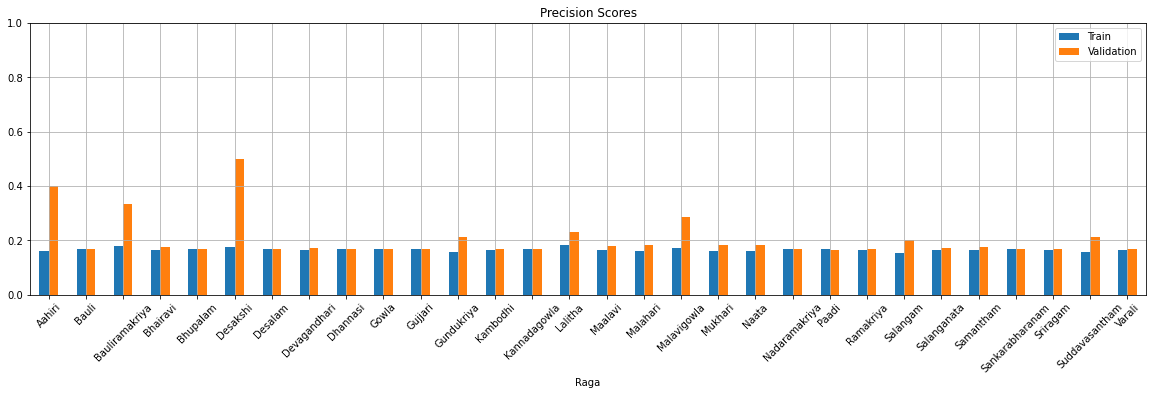

In [16]:
bar_plot(tab, ['train_precision','validation_precision'],'Precision Scores')

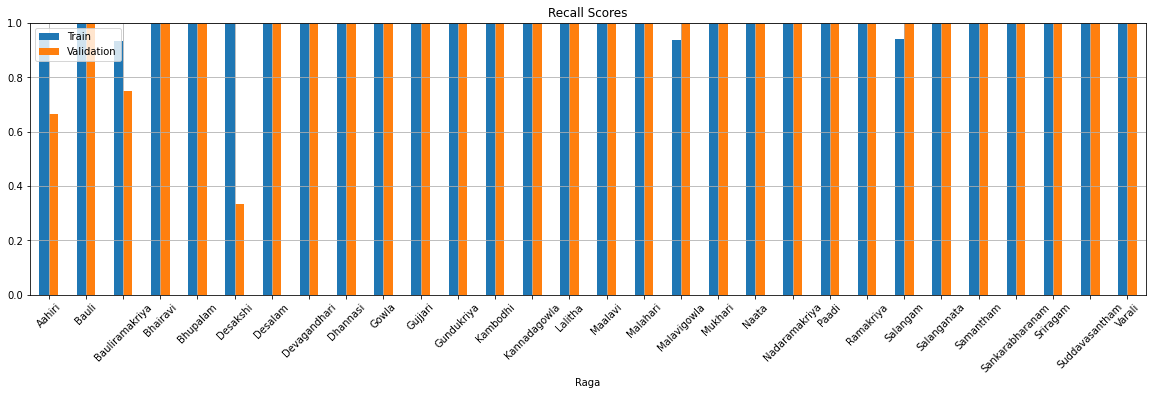

In [17]:
bar_plot(tab, ['train_recall','validation_recall'],'Recall Scores')